# Exploring Large Digital Libraries by Multimodal Criteria

<a id='top_of_page'></a>
## Version: January 2023

The original publication is available [online](https://link.springer.com/chapter/10.1007%2F978-3-319-43997-6_24).


## Why to Read this Tutorial?
* In this tutorial, you will learn to read metadata from an OAI-PMH data provider and how to convert the retrieved data from Dublin Core to a pandas data frame.
* Furthermore, you will carry out some basic data analysis on your data in order to find out if the data is corrupt or unclean. Based on an example, you will clean some aspects of your data.
* Finally, you will analyse and visualize the data with the help of a network graph.

![title](img/architecture.png)

### Index

[To Dos](#continue_from_here)



### Preparations
The following code snippet initializes your Python run-time enviroment in order to run all of the subsequent actions.

If you have installed everything correctly with the help of [Anaconda](https://www.continuum.io/downloads) as explained in [dst4l0.ipynb](https://github.com/elektrobohemian/dst4l-copenhagen/blob/master/dst4l0.ipynb), the following packages should be installed correctly and be importable without problems.

#### Additional Configuration of This Notebook

In [128]:
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set 'allowDownloads' to True, all images will be downloaded and processed again
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
allowDownloads=True # should be True if you run this for the first time

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# Download directory used for images etc.
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
downloadDir="./tmp/"

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# Keep original downloaded TIFF images? Otherwise, they will be deleted and only JPEG thumbnails remain after download.
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

keepTIFFs=False

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set 'demoClustering' to False, the clustering steps will take about 2 hours
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
demoClustering=False # should be False if you run this for the first time

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set 'allowComputationallyExpensiveCalculations' to True, various time consuming tasks (some of them running 
# several hours) will be carried out and not only loaded from pre-computed data files
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
allowComputationallyExpensiveCalculations=True # should be True if you run this for the first time

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# Enabling this action activates exact string matching againt name lists
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
allowExactStringMatching=True

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set to True, some plots will be saved as PDF documents in ./figures/
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
saveFiguresAsPDF=True

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set to True, Google Map API will be used to resolve location names, if False OpenStreetMap will be used
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *i
useGoogleMapsAPI=False
privateGoogleKey='ENTER YOUR KEY HERE' #if you want to use Google, you need a personal key

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If set to True, OpenStreetMap API will be used to fetch spatial names and alternative localized names, should be True at first run
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
getSpatialNamesFromOSM=False

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If set to True, details per PPN will be saved as separate JSON files in "jsonWebDir"
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
serializePPNLookup2JSON=False
jsonWebDir="./web/data/ppn/"

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If set to True, the raw features created by the Java application will be read from disk and converted for further usage, must be True at first run
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
reinterpretVisualWordRawFeatures=False

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If set to True, a HTTP webserver will be started after all cells have been processed to show the results
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
launchHTTPServer=False

In [127]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 40)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import json
import networkx as nx # network analysis
from networkx.readwrite import json_graph
import itertools
import os.path
from datetime import datetime # for time measurement
import sys
import os
import pickle
import subprocess as subp
import gzip
import math
import codecs

from jellyfish import jaro_distance, jaro_winkler, hamming_distance, levenshtein_distance
import scipy.cluster.hierarchy as scipycluster
from sklearn.feature_extraction.text import TfidfVectorizer

from skimage import io, exposure
from scipy.spatial import distance
# import the k-means algorithm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin,pairwise_distances_argmin_min, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

# OAI
from sickle import Sickle

# image handling
from PIL import Image

# geo stuff
import googlemaps
from geopy.distance import geodesic
import geojson as gj

def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()
    
def pickleCompress(fileName,pickledObject):
    printLog("Pickling to '%s'" %fileName)
    f = gzip.open(fileName,'wb')
    pickle.dump(pickledObject,f)
    f.close()
    printLog("Pickling done.")
    
def pickleDecompress(fileName):
    #restore the object
    printLog("Depickling from '%s'" %fileName)
    f = gzip.open(fileName,'rb')
    pickledObject = pickle.load(f)
    f.close()
    printLog("Depickling done.")
    return pickledObject

if not os.path.exists(downloadDir):
        os.makedirs(downloadDir)
if not os.path.exists("./picklez/"):
        os.makedirs("./picklez/")
if not os.path.exists("./figures/"):
        os.makedirs("./figures/")
if not os.path.exists("./graphs/"):
        os.makedirs("./graphs/")
if not os.path.exists("./graphs/generics/"):
        os.makedirs("./graphs/generics/")        
if not os.path.exists("./html/"):
        os.makedirs("./html/")
if not os.path.exists("./web/"):
        os.makedirs("./web/")
if not os.path.exists("./web/qa/"):
        os.makedirs("./web/qa/")
if not os.path.exists("./web/data/"):
        os.makedirs("./web/data/")
if not os.path.exists("./web/data/ppn/"):
        os.makedirs("./web/data/ppn/")
if not os.path.exists("./web/data/layers/"):
        os.makedirs("./web/data/layers/")

## Extraction: Retrieving Data
### Connecting to the OAI-conform Repository and Downloading Metadata Records

The next cell connects to the Berlin State Library OAI-PMH server to download metadata records in the [Dublin Core format](http://dublincore.org/) as part of the extract step of the ETL process.

The records are then saved locally to work with them later in the sense of a local work area. For the sake of simplicity, the saving relies on the pickling mechanism of Python - its built-in object serialization method. In a productive use case, you might reach the limits of the pickle package because of the resulting file size. A viable alternative is [HDF5](https://www.h5py.org/).

Please note that each metadata record is retrieved separately via HTTP which is not very efficient and very time-consuming. To give you an impression, a run with 120,000 records on 2022-12-30 lasted about 1.5 hours:

```
[2022-12-30 16:15:09.736765]	Starting OAI-PMH record download...
...
[2022-12-30 17:38:17.746090]	Finished OAI-PMH download of 120000 records.
```

If you want to skip this step, a sample of 120,000 records is [available for download](https://8bit-inferno.de/_persistent/save_120k_dc_all.pickle). The download must be placed in the working directory of this Jupyter notebook.

If you want to use this sample dataset make sure to uncomment line #4.

In [130]:
# a list of saved metadata records
savedRecords=[]

# download override (e.g., when using the sample dataset)
#allowDownloads=False

if allowDownloads:
    # connect to a metadata repository
    sickle = Sickle('http://digital.staatsbibliothek-berlin.de/oai')

    # for debugging purposes you might want to uncomment the following commands
    # get the sets from the data provider connected to
    #sets = sickle.ListSets()
    # print the returned sets including their identifiers
    #print("Sets provided by data provider\n* * * * * * * * * * * * * * * * * * * * * ") # \n creates a new line
    #for s in sets:
    #    print("'"+s.setName+"' accessible via: '"+s.setSpec+"'")

    # get the records from this repository's specific document set 'DC_krieg.1914.1918' (documents related to World War I) 
    # using Dublin Core format 
    records = sickle.ListRecords(metadataPrefix='oai_dc', set='all')

    printLog("Starting OAI-PMH record download...")
    # initialize some variables for counting and saving the metadata records
    savedDocs=0
    # number of metadata records to be retrieved
    maxDocs=120000 
    # 100 is just for testing, for more interesting results increase this value to 1000. ATTENTION! this will also take more time for reading data.
    #maxDocs=100
    
    # save the records locally as we don't want to have to rely on a connection to the OAI-PMH server all the time
    # iterate over all records until maxDocs is reached
    # ATTENTION! if you re-run this cell, the contents of the savedRecords array will be altered!
    for record in records:
        # get the PPN of the digitized work as the DC identifier will reference different (analog) manifestations
        tokens=record.header.identifier.split(":")
        tokens
        for t in tokens:
            if t.startswith("PPN"):
                # the array building simply fixes the issue that all DC field come as arrays
                record.metadata['PPN']=[t]
        
        # check if we reach the maximum document value
        if savedDocs<maxDocs:
            savedDocs=savedDocs+1
            # save the current record to the "savedRecords" array
            savedRecords.append(record.metadata)
            if savedDocs%1000==0:
                printLog("Downloaded %d of %d records."%(savedDocs,maxDocs))
        # if so, end the processing of the for-loop
        else:
            break # break ends the processing of the loop

    printLog("Finished OAI-PMH download of "+str(len(savedRecords))+" records.")
    pickle.dump( savedRecords, open( "save_120k_dc_all.pickle", "wb" ) )
else:
    printLog("Loading OAI-PMH records from disk...")
    savedRecords=pickle.load( open( "save_120k_dc_all.pickle", "rb" ) )
    printLog("Done.")

[2022-12-30 16:15:09.736765]	Starting OAI-PMH record download...
[2022-12-30 16:15:45.882497]	Downloaded 1000 of 120000 records.
[2022-12-30 16:16:23.556119]	Downloaded 2000 of 120000 records.
[2022-12-30 16:17:00.626207]	Downloaded 3000 of 120000 records.
[2022-12-30 16:17:39.335954]	Downloaded 4000 of 120000 records.
[2022-12-30 16:18:16.456924]	Downloaded 5000 of 120000 records.
[2022-12-30 16:18:51.011453]	Downloaded 6000 of 120000 records.
[2022-12-30 16:19:28.799323]	Downloaded 7000 of 120000 records.
[2022-12-30 16:20:11.293473]	Downloaded 8000 of 120000 records.
[2022-12-30 16:20:45.905295]	Downloaded 9000 of 120000 records.
[2022-12-30 16:21:21.233754]	Downloaded 10000 of 120000 records.
[2022-12-30 16:21:59.223058]	Downloaded 11000 of 120000 records.
[2022-12-30 16:22:33.426008]	Downloaded 12000 of 120000 records.
[2022-12-30 16:23:07.011803]	Downloaded 13000 of 120000 records.
[2022-12-30 16:23:40.923640]	Downloaded 14000 of 120000 records.
[2022-12-30 16:24:13.797295]	Downl

In the next step, all images are downloaded, downscaled and converted to the JPEG format.

This step combines an extraction process step relying on HTTP, and two transformation steps:

1. the downscale of the retrieved TIFF images, and
2. the conversion of the extracted TIFF images to the compressed JPEG format

In [5]:
# uncomment this cell if you want to split the image download to two different computers
# in this case, one computer will use "even_dc_all.pickle" while the other will use "odd_dc_all.pickle" in the next cell

#availableKeys=dict()
#evenRecords=[]
#oddRecords=[]

#for i,r in enumerate(savedRecords):
#    for k in r.keys():
#        if not k in availableKeys:
#            availableKeys[k]=1
#        else:
#            availableKeys[k]=availableKeys[k]+1
#    if i%2==0:
#        evenRecords.append(r)
#    else:
#        oddRecords.append(r)

#pickle.dump( evenRecords, open( "even_dc_all.pickle", "wb" ) )
#pickle.dump( oddRecords, open( "odd_dc_all.pickle", "wb" ) )

In [6]:
# uncomment this line if you are continuing the execution of this notebook at a later point in time
#savedRecords=pickle.load( open( "save_120k_dc_all.pickle", "rb" ) )

tiffDownloadPath="https://content.staatsbibliothek-berlin.de/dms/%PPN%/800/0/00000001.tif?original=true"
    
countSavedRecords=len(savedRecords)
printLog("Started image download and processing. This will take a while...")
#logFile = open("/Volumes/2TB_WD/sbb_images/downloadIssues.txt", "w")
logFile = open(downloadDir+"/downloadIssues.txt", "w")

# surpress PIL's DecompressionBombErrors and Warnings
Image.MAX_IMAGE_PIXELS = None

for i,record in enumerate(savedRecords):
    if i%1000==0:
        if allowDownloads:
            printLog("Downloaded %d of %d images."%(i,countSavedRecords))
    
    ppn=""
    for r in record["identifier"]:
        if r.startswith("PPN"):
            ppn=r
            break
    #if len(record["identifier"])>1:
    #    ppn=str(record["identifier"][1])
    #else:
    #    ppn=str(record["identifier"][0])
    ppnTIFF=ppn+".tif"
    ppnJPEGPAth=downloadDir+ppn+".jpg"
    #if "object" in record.keys() and allowDownloads:
    if allowDownloads:
        httpCode=200
        # prevent downloading of already present files
        if not os.path.isfile(ppnJPEGPAth) :
            tryDownload=True
            # check for the HTTP error code, maybe the file does not exist
            try:
                response=urllib.request.urlopen(tiffDownloadPath.replace("%PPN%",ppn))
            except urllib.error.HTTPError as ex:
                #print("Error with %s"%tiffDownloadPath.replace("%PPN%",ppn))
                httpCode=ex.code
                tryDownload=False
            if tryDownload:
                #if allowDownloads:
                urlinfo=urllib.request.urlretrieve(tiffDownloadPath.replace("%PPN%",ppn),downloadDir+ppnTIFF)
                img = Image.open(downloadDir+ppnTIFF)
                img.thumbnail((512,512))
                img.save(downloadDir+ppn+".jpg")
                if not keepTIFFs:
                    os.remove(downloadDir+ppnTIFF)
                #ret=subp.call(["mogrify", "-resize","512x512","-format", "jpg",downloadDir+ppnTIFF])
                #if ret!=0:
                #    print("Problem with mogrifying "+ppnTIFF)
                #    logFile.write("[MOGRIFY]: %s \n%s\n\n" % (str("Problem with mogrifying "+ppnTIFF),str("Downloaded from: "+record["object"][0])))
                #ret=subp.call(["rm",downloadDir+ppnTIFF])
                #if ret!=0:
                #    print("Problem with removing "+ppnTIFF)
                #    logFile.write("[REMOVAL]: %s\n\n" % "Problem with removing "+ppnTIFF)
            else:
                print("Problem with accessing "+ppnTIFF+ " @ "+tiffDownloadPath.replace("%PPN%",ppn)+" due to HTTP code: "+str(httpCode))
                logFile.write("[HTTP]: %s\n\n" % "Problem with accessing "+tiffDownloadPath.replace("%PPN%",ppn))
                logFile.write("\tHTTP Code: "+str(httpCode)+"\n")
                #logFile.write(str(urlinfo[1])+"\n\n")
    else:
        logFile.write("[OBJECT key missing]: %s\n\n" % str(record))
logFile.close()
print("\n")
if allowDownloads:
    printLog("Finished image download and processing.")
else:
    printLog("Skipped image download and processing.")

[2022-12-29 17:21:53.256923]	Started image download and processing. This will take a while...


[2022-12-29 17:21:53.960605]	Skipped image download and processing.


Please note that images will not be downloaded for some metadata records. This is no error because periodicals or multivolume work do not come with presentation images.

## Transformation: Creating a Dataframe from the Metadata Records

Creating a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) is always a good idea if you want to work with your data in a tabular way as it provides means to export, select, and analyse the data. There are many more opportunities, e.g., you can even use dataframes to pose queries on the data.

In the next cell, the downloaded data is converted to a Python dict that will then be converted to a dataframe in a, honestly speaking, very verbose way...

In [318]:
# load the records
printLog("Loading pickled records...")
# uncomment this line if you are continuing the execution of this notebook at a later point in time
savedRecords=pickle.load( open( "save_120k_dc_all.pickle", "rb" ) )
printLog("Finished loading pickled records.")

availableKeys=dict()

# check for all keys present in the previously downloaded dataset
for i,r in enumerate(savedRecords):
    for k in r.keys():
        if not k in availableKeys:
            availableKeys[k]=1
        else:
            availableKeys[k]=availableKeys[k]+1
    
print(availableKeys)

# create a dictionary for the records
values=dict()
# take the keys as they have found within the downloaded OAI records
keys=availableKeys.keys()
# for every metadata field, create an empty array as the content of the dictionary filed under the key 'k'
for k in keys:
    values[k]=[]
# in addition, store the PPN (the SBB's unique identifier for digitized content)    
#values["PPN"]=[]

# iterate over all saved records
for record in savedRecords:
    # we cannot iterate over the keys of record.metadata directly because not all records cotain the same fields,...
    for k in keys:
        # thus we check if the metadata field 'k' has been created above
        if k in values:
            # append the metadata fields to the dictionary created above
            # if the metadata field 'k' is not available input "None" instead
            #values[k].append(record.get(k,["None"])[0].encode('ISO-8859-1'))
            if k in record:
                value=record.get(k)[0]
                if value:
                    if value.isdigit():
                        value=int(value)
                    else:
                        #p27 value=value.encode('ISO-8859-1')
                            #value=value.encode('ISO-8859-1').decode("utf-8", "backslashreplace")
                        value=value
                    values[k].append(value)
                else:
                    values[k].append(np.nan)
            else:
                values[k].append(np.nan)
# create a data frame from the 
#p27 df=pd.DataFrame(pd.to_numeric(values,errors='coerce'))
df=pd.DataFrame(values)
df['date']=pd.to_numeric(df['date'],errors='ignore',downcast='integer')
#df=pd.DataFrame(values)
#df=df.convert_objects(convert_dates=False, convert_numeric=True, convert_timedeltas=False, copy=True)
df.shape

[2023-01-01 17:19:44.056613]	Loading pickled records...
[2023-01-01 17:19:46.081895]	Finished loading pickled records.
{'title': 120000, 'creator': 88841, 'subject': 119901, 'publisher': 58920, 'type': 120000, 'format': 120000, 'identifier': 120000, 'language': 73020, 'date': 117074, 'coverage': 109411, 'rights': 113648, 'PPN': 120000}


(120000, 12)

The next cell is almost equal to the above but we compare the recently retrieved dataset against a historical one.

A historical sample from 2021 can be downloaded [here](https://8bit-inferno.de/_persistent/save_120k_dc_all_2021.pickle).

In [319]:
# load the records
printLog("Loading pickled records...")
# uncomment this line if you are continuing the execution of this notebook at a later point in time
savedRecords=pickle.load( open( "save_120k_dc_all_2021.pickle", "rb" ) )
printLog("Finished loading pickled records.")

availableKeys=dict()

# check for all keys present in the previously downloaded dataset
for i,r in enumerate(savedRecords):
    for k in r.keys():
        if not k in availableKeys:
            availableKeys[k]=1
        else:
            availableKeys[k]=availableKeys[k]+1
    
print(availableKeys)

# create a dictionary for the records
values=dict()
# take the keys as they have found within the downloaded OAI records
keys=availableKeys.keys()
# for every metadata field, create an empty array as the content of the dictionary filed under the key 'k'
for k in keys:
    values[k]=[]
# in addition, store the PPN (the SBB's unique identifier for digitized content)    
#values["PPN"]=[]

# iterate over all saved records
for record in savedRecords:
    # we cannot iterate over the keys of record.metadata directly because not all records cotain the same fields,...
    for k in keys:
        # thus we check if the metadata field 'k' has been created above
        if k in values:
            # append the metadata fields to the dictionary created above
            # if the metadata field 'k' is not available input "None" instead
            #values[k].append(record.get(k,["None"])[0].encode('ISO-8859-1'))
            if k in record:
                value=record.get(k)[0]
                if value:
                    if value.isdigit():
                        value=int(value)
                    else:
                        #p27 value=value.encode('ISO-8859-1')
                            #value=value.encode('ISO-8859-1').decode("utf-8", "backslashreplace")
                        value=value
                    values[k].append(value)
                else:
                    values[k].append(np.nan)
            else:
                values[k].append(np.nan)
# create a data frame from the 
#p27 df=pd.DataFrame(pd.to_numeric(values,errors='coerce'))
df_2021=pd.DataFrame(values)
df_2021['date']=pd.to_numeric(df_2021['date'],errors='ignore',downcast='integer')
#df=pd.DataFrame(values)
#df=df.convert_objects(convert_dates=False, convert_numeric=True, convert_timedeltas=False, copy=True)
df_2021.shape

[2023-01-01 17:19:46.933681]	Loading pickled records...
[2023-01-01 17:19:50.106982]	Finished loading pickled records.
{'title': 120000, 'creator': 96090, 'subject': 119989, 'type': 120000, 'format': 120000, 'identifier': 120000, 'language': 89713, 'date': 120000, 'relation': 114947, 'coverage': 101010, 'PPN': 120000, 'publisher': 55127, 'rights': 90158}


(120000, 13)

### Quality Control of the Extraction and Transformation

With two datasets at hand, we can check for syntactical differences between the recently retrieved and the old dataset. For instance, it is important whether the same Dublin Core fields are available as the following processing steps might rely on them.

In [320]:
l1=len(list(df.columns))
l2=len(list(df_2021.columns))

if l1!=l2:
    print("Warning! Number of Dublin Core fields differ between datasets.\n")
    sl1=sorted(list(df.columns))
    sl2=sorted(list(df_2021.columns))
    print("Current Dublin Core dataset contains %i fields."%l1)
    print(sl1)
    print("2021 Dublin Core dataset contains %i fields."%l2)
    print(sl2,"\n")
    print("Elements only available in old dataset: ",list(set(sl2) - set(sl1)))
    print("Elements only available in new dataset: ",list(set(sl1) - set(sl2)))

Warning! Number of Dublin Core fields differ between datasets.

Current Dublin Core dataset contains 12 fields.
['PPN', 'coverage', 'creator', 'date', 'format', 'identifier', 'language', 'publisher', 'rights', 'subject', 'title', 'type']
2021 Dublin Core dataset contains 13 fields.
['PPN', 'coverage', 'creator', 'date', 'format', 'identifier', 'language', 'publisher', 'relation', 'rights', 'subject', 'title', 'type'] 

Elements only available in old dataset:  ['relation']
Elements only available in new dataset:  []


After a first inspection, the transformed data is serialized for later usage.

In [321]:
# creating a PPN list in CSV format is handy if you want to use it with sbbget from StabiHacks
df.PPN.to_csv("120k_ppn_list.csv",index=False,header=False)

# in case you want to use this data frame somewhere else, here are some sample serializations
printLog("Serializing data frame...")
# Microsoft Excel
df.to_excel("120k_sbb_sample.xlsx")
# HDF5 format
df.to_hdf("120k_sbb_sample.hdf5",key="sbb")
printLog("Done.")

[2023-01-01 17:19:58.128844]	Serializing data frame...


/Users/david/src/SBBrowse2018/venv/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['title', 'creator', 'subject', 'publisher', 'type', 'format', 'identifier', 'language', 'date', 'coverage', 'rights', 'PPN'], dtype='object')]

  pytables.to_hdf(


[2023-01-01 17:20:18.096075]	Done.


### Inspecting Data in Detail

Besides the check of the syntax of the obtained data, it is important to inspect it in detail to discover its content. This first inspection will give us an impression of what to expect and how the Dublin Core fields are used.

In [322]:
df.head()

,title,creator,subject,publisher,type,format,identifier,language,date,coverage,rights,PPN
0,"Collegium Ethicum, In Quo De Summo Hominis Bon...","Liebenthal, Christianus",Historische Drucke,Hampelius,monograph,application/mets+xml,PPN1000000974,lat,1620,Giessae Hessorum,Public Domain Mark 1.0,PPN1000000974
1,"Augustini Niphi, Philosophi Suessani De Auguri...","Niphus, Augustinus",Historische Drucke,Egenolphus,monograph,application/mets+xml,PPN100000127X,lat,1614,Marpurgi,Public Domain Mark 1.0,PPN100000127X
2,Concerto pour la Flûte avec Accompagnement de ...,"Danzi, Franz",Musiknoten,Breitkopf & Härtel,monograph,application/mets+xml,PPN1000006808,NaN,1806,Leipsic,CC BY-NC-SA 4.0 International,PPN1000006808
3,Schuldige Condolentz-Zeilen Womit seinem Gelie...,"Koltemann, Otto Benedict",Historische Drucke,Königliche privil. Buchdruckerey,monograph,application/mets+xml,PPN1000056597,ger,1719,Glückstadt,Public Domain Mark 1.0,PPN1000056597
4,Johann Friedrich Böttchers der Arzney und Wund...,"Böttcher, Johann Friedrich",Historische Drucke,Oehmigke,monograph,application/mets+xml,PPN1000059669,ger,1796,Berlin,Public Domain Mark 1.0,PPN1000059669


In [323]:
df_2021.head()

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights
0,Brief von Fritz von Unruh an Margarete Hauptmann,"Unruh, Fritz von",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771784589,de,NaN,Nachlass Gerhart Hauptmann digital,o.O.,PPN771784589,NaN,NaN
1,Brief an Wilhelm Speyer; 05.11.1832,"Speyer, Wilhelm",Musik,manuscript,application/mets+xml,PPN796368198,NaN,NaN,Nachlässe und Autographe digital,Cassel,PPN796368198,NaN,NaN
2,Plan einer pflanzengeographischen Uebersicht v...,"Schouw, Joakim Frederik",Alexander von Humboldt,manuscript,application/mets+xml,PPN82636702X,de,NaN,Nachlass Alexander von Humboldt digital,NaN,PPN82636702X,NaN,NaN
3,Brief von Erika Hamburger an Gerhart Hauptmann,"Hamburger, Erika",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771806655,de,NaN,Nachlass Gerhart Hauptmann digital,Neukirch [Breslau],PPN771806655,NaN,NaN
4,"Musicalischen Divertissiments, oder In das Geh...","Bodino, Sebastiano",Musiknoten,multivolume_work,application/mets+xml,PPN667471367,NaN,1726,NaN,Augspurg,PPN667471367,Leopold,NaN


Obviously, the _PPN_ (Pica production number, [see this report for more details](https://doi.org/10.5281/zenodo.2702543)) serves as a unique identifier, so we have to make sure that all records contain one.

In [324]:
df[df.PPN.isnull()].count()

title         0
creator       0
subject       0
publisher     0
type          0
format        0
identifier    0
language      0
date          0
coverage      0
rights        0
PPN           0
dtype: int64

Usually, we know that some columns should only contain unique values, e.g., the PPN column. Hence, it is a good starting point for the analysis to validate this hypothesis with the help of the following function.

In [325]:
# checks for unique values in each column
def uniqueValues(currentDataFrame):
    colNames=currentDataFrame.columns.values.tolist()
    for colName in colNames:
        print(colName+";\t\t unique values:\t"+str(len(currentDataFrame[colName].unique()))+ "\t total count: "+str(currentDataFrame[colName].count()))

uniqueValues(df)

title;		 unique values:	102550	 total count: 119998
creator;		 unique values:	29543	 total count: 88841
subject;		 unique values:	50	 total count: 119901
publisher;		 unique values:	15263	 total count: 58920
type;		 unique values:	8	 total count: 120000
format;		 unique values:	1	 total count: 120000
identifier;		 unique values:	119997	 total count: 120000
language;		 unique values:	114	 total count: 73020
date;		 unique values:	1440	 total count: 117074
coverage;		 unique values:	5558	 total count: 109411
rights;		 unique values:	8	 total count: 113648
PPN;		 unique values:	119997	 total count: 120000


In the unfortunate case that not all entries in the PPN column are unique, we might have retrieved duplicates. In other works, some works appear more than one time in the retrieved dataset. 

This is an observation we should definitely take care of later, in particular if the duplicates contain conflicting assertions. Thus, we should inspect these records in detail.

In [327]:
uniquePPNs = df["PPN"]
df[uniquePPNs.isin(uniquePPNs[uniquePPNs.duplicated()])].sort_values("PPN")

,title,creator,subject,publisher,type,format,identifier,language,date,coverage,rights,PPN
39269,"D. Philipp Jacob Speners, Churfürstl. Brandenb...","Spener, Philipp Jakob",Historische Drucke,Christoph Seidels Wittwe,volume,application/mets+xml,PPN1682146324,ger,1742,Magdeburg,Public Domain Mark 1.0,PPN1682146324
39270,"D. Philipp Jacob Speners, Churfürstl. Brandenb...","Spener, Philipp Jakob",Historische Drucke,Christoph Seidels Wittwe,volume,application/mets+xml,PPN1682146324,ger,1742,Magdeburg,Public Domain Mark 1.0,PPN1682146324
71860,Han i araha gu wen yuwan giyan bithe (Teildigi...,NaN,Historische Drucke,NaN,monograph,application/mets+xml,PPN3306131008,mnc,NaN,NaN,NaN,PPN3306131008
71861,Han i araha gu wen yuwan giyan bithe = 御製古文淵鑑,聖祖,Historische Drucke,[內府刻本],multivolume_work,application/mets+xml,PPN3306131008,mnc,1685,[京都],UNKNOWN,PPN3306131008
71873,Han i araha manju monggo nikan hergen ilan hac...,NaN,Historische Drucke,NaN,monograph,application/mets+xml,PPN330613113X,mnc,NaN,NaN,NaN,PPN330613113X
71874,Han i araha manju monggo nikan hergen ilan hac...,NaN,Historische Drucke,NaN,multivolume_work,application/mets+xml,PPN330613113X,mnc,NaN,NaN,UNKNOWN,PPN330613113X


### Classification of Data with the Help of Regular Expressions

As our last observation made us sceptical about the general data quality, we should analyse the data in more detail. Regular expressions are a handy means in order to analyse columns that we expect to follow a certain internal structure or pattern.

The next cell creates various regular expression to discover positive or negative numbers, different date ranges, emails, ISBN numbers or the like.


In [328]:
# regular expressions taken from: http://stackoverflow.com/questions/1449817/what-are-some-of-the-most-useful-regular-expressions-for-programmers
# extended by David Zellhöfer

patterns=dict()
#^ beginning of string, $ end of string, \d digits +: once or more times
patterns["positiveInteger"]="^\d+$"
patterns["negativeInteger"]="^-\d+$"
patterns["generalInteger"]="^-?\d+$"
patterns["positiveFloat"]="^\d*\.\d+$"
patterns["negativeFloat"]="^-\d*\.\d+$"
patterns["generalFloat"]="^-?\d*\.\d+$"
patterns["positiveGermanFloat"]="^\d*,\d+$"
patterns["negativeGermanFloat"]="^-\d*,\d+$"
patterns["generalGermanFloat"]="^-?\d*,\d+$"
# Date (dd mm yyyy, d/m/yyyy, etc.), in range 1000-2099 without proper February handling
patterns["dateVariant"]="^([1-9]|0[1-9]|[12][0-9]|3[01])\D([1-9]|0[1-9]|1[012])\D(1[0-9][0-9][0-9]|20[0-9][0-9])$"
patterns["year"]="^(1[0-9][0-9][0-9]|20[0-9][0-9])$"
patterns["ancientYear"]="^([0-1]?[0-9][0-9][0-9]|20[0-9][0-9])$"
patterns["century"]="^(1[0-9][Xx][Xx]|20[Xx][Xx])$"
patterns["ancientCentury"]="^([0-1]?[0-9][Xx][Xx]|20[Xx][Xx])$"
patterns["decade"]="^(1[0-9][0-9][Xx]|20[0-9][Xx])$"
patterns["ancientDecade"]="^([0-1]?[0-9][0-9][Xx]|20[0-9][Xx])$"
# year range with splitter "- / :", the splitter can be surrounded by an arbitrary amount of whitespaces (\s)
patterns["rangeYear"]="^\s*(1[0-9][0-9][0-9]|20[0-9][0-9])\s*(\-|\/|:)\s*(1[0-9][0-9][0-9]|20[0-9][0-9])\s*$"
patterns["rangeCentury"]="^\s*(1[0-9][Xx][Xx]|20[Xx][Xx])\s*(\-|\/|:)\s*(1[0-9][Xx][Xx]|20[Xx][Xx])\s*$"
patterns["rangeAncientYear"]="^\s*([0-1]?[0-9][0-9][0-9]|20[0-9][0-9])\s*(\-|\/|:)\s*(1[0-9][0-9][0-9]|20[0-9][0-9])\s*$"
patterns["rangeAncientCentury"]="^\s*([0-1]?[0-9][Xx][Xx]|20[Xx][Xx])\s*(\-|\/|:)\s*(1[0-9][Xx][Xx]|20[Xx][Xx])\s*$"
patterns["rangeYear2Digit"]="^\s*(1[0-9][0-9][0-9]|20[0-9][0-9])\s*(\-|\/|:)\s*([0-9][0-9])\s*$"
patterns["rangeDateVariant"]="^\s*([1-9]|0[1-9]|[12][0-9]|3[01])\D([1-9]|0[1-9]|1[012])\D(1[0-9][0-9][0-9]|20[0-9][0-9])\s*(\-|\/|:)\s*([1-9]|0[1-9]|[12][0-9]|3[01])\D([1-9]|0[1-9]|1[012])\D(1[0-9][0-9][0-9]|20[0-9][0-9])\s*$"

patterns["email"]="^[_]*([a-z0-9]+(\.|_*)?)+@([a-z][a-z0-9-]+(\.|-*\.))+[a-z]{2,6}$"
patterns["domain"]="^([a-z][a-z0-9-]+(\.|-*\.))+[a-z]{2,6}$"
patterns["url"]="^https?\:\/\/[a-zA-Z0-9.-]+\.[a-zA-Z]{2,3}\/?$"
patterns["ipv4"]="^(?:\d{1,3}\.){3}\d{1,3}$"
patterns["rgbHex"]="^#([a-fA-F0-9]{6}|[a-fA-F0-9]{3})$"
patterns["generalHex"]="^#[a-fA-F0-9]*$"
 
patterns["isbnPrefix"]="^ISBN(-1(?:(0)|3))?:?\x20(\s)*[0-9]+[- ][0-9]+[- ][0-9]+[- ][0-9]*[- ]*[xX0-9]$"
patterns["isbn"]="^[0-9]+[- ][0-9]+[- ][0-9]+[- ][0-9]*[- ]*[xX0-9]$"
patterns["NaN"]="^[Nn][Aa][Nn]$"

Now, it is time to find out if all date columns match the patterns specified above. Additionally, we will plot the results to assess the data's quality.

In [329]:
rowCount=0
histogram=dict()
# check if records' date columns match a given pattern
for row in df.iterrows():
    rowCount=rowCount+1
    readDate=str(row[1]["date"])
    matchedOnce=False
    for key in patterns:
        p=re.compile(patterns[key])
        m = p.search(readDate)
        if m:
            if not key in histogram:
                histogram[key]=0
            histogram[key]=histogram[key]+1
            matchedOnce=True
        else:
            pass
    if not matchedOnce:
        print("No matches at all: "+row[1]["PPN"]+"\t for: "+str(readDate))
print("Row count: "+str(rowCount))
print(histogram)   


No matches at all: PPN1001062361	 for: 1818-04-25
No matches at all: PPN1001062531	 for: 1808-04-29
No matches at all: PPN1001062566	 for: 1813-11-14
No matches at all: PPN100106271X	 for: 1816-03-10
No matches at all: PPN1002304954	 for: 1838-09-29
No matches at all: PPN1002305152	 for: 1846-03-10
No matches at all: PPN1002305721	 for: 1871-03-17
No matches at all: PPN1002305810	 for: 1845-08-23
No matches at all: PPN1002347475	 for: 1829-08-18
No matches at all: PPN1002347793	 for: 1859-09-04
No matches at all: PPN1003356826	 for: 1828-01-22
No matches at all: PPN1003414427	 for: 1831-06-28
No matches at all: PPN100405131X	 for: 1829-03-01
No matches at all: PPN1004051808	 for: 1859-04-24
No matches at all: PPN101005810X	 for: 1839-06-19
No matches at all: PPN1023111349	 for: 1819-11-20
No matches at all: PPN1023111926	 for: 1819-12-07
No matches at all: PPN1023112183	 for: 1819-12-13
No matches at all: PPN1023112981	 for: 1820-02-25
No matches at all: PPN1023114720	 for: 1820-03-20


No matches at all: PPN1047639351	 for: 1823-07-09
No matches at all: PPN1047639602	 for: 1823-07-03
No matches at all: PPN104763970X	 for: 1827-01-19
No matches at all: PPN1047640007	 for: 1827-03-27
No matches at all: PPN1047640155	 for: 1828-01-12
No matches at all: PPN1047652951	 for: 1843-07-14
No matches at all: PPN104765380X	 for: 1843-02-14
No matches at all: PPN1047657341	 for: 1843-05-24
No matches at all: PPN1047657392	 for: 1846-05-21
No matches at all: PPN1047662175	 for: 1843-07-20
No matches at all: PPN1047663430	 for: 1844-04-14
No matches at all: PPN1047663465	 for: 1843-09-04
No matches at all: PPN1047663473	 for: 1843-08-16
No matches at all: PPN1047693631	 for: 1843-10-25
No matches at all: PPN1047693666	 for: 1846-01-24
No matches at all: PPN1047693674	 for: 1842-03-06
No matches at all: PPN1047693739	 for: 1841-06-11
No matches at all: PPN1047693763	 for: 1840-01-30
No matches at all: PPN1047693798	 for: 1842-09-27
No matches at all: PPN1047693828	 for: 1841-02-04


No matches at all: PPN1784492108	 for: 1831-07-31
No matches at all: PPN1784492507	 for: 1831-12-23
No matches at all: PPN1784929433	 for: 1934-05-15
No matches at all: PPN1786144506	 for: 1826-04-10
No matches at all: PPN1800288948	 for: 1830-06-24
No matches at all: PPN1807315088	 for: 1829-07-30
No matches at all: PPN1808799976	 for: 1821-07-21
No matches at all: PPN1814205810	 for: 1846-02-13
No matches at all: PPN1814206310	 for: 1833-08-03
No matches at all: PPN1814206833	 for: 1830-08-06
No matches at all: PPN1814207090	 for: 1841-07-08
No matches at all: PPN1814208003	 for: 1841-02-06
No matches at all: PPN1816650463	 for: 1776-09-25
No matches at all: PPN1816653470	 for: 1777-01-20
No matches at all: PPN1816654663	 for: 1777-02-12
No matches at all: PPN1816915025	 for: 1877-12-23
No matches at all: PPN3303600473	 for: 16XX-1867
No matches at all: PPN666097402	 for: um 1100
No matches at all: PPN679598049	 for: 1887-02-03
No matches at all: PPN679598413	 for: 1887-02-25
No matc

No matches at all: PPN72787571X	 for: 1839-10-03
No matches at all: PPN727880926	 for: 1785-12-30
No matches at all: PPN729079341	 for: 1870-08-26
No matches at all: PPN729182622	 for: 1893-01-11
No matches at all: PPN729184951	 for: 1879-11-04
No matches at all: PPN729185281	 for: 1880-10-18
No matches at all: PPN729185907	 for: 1881-01-25
No matches at all: PPN72919499X	 for: 1881-12-22
No matches at all: PPN731527143	 for: 16XX [17. Jahrhundert]
No matches at all: PPN731833155	 for: 1842-10-10
No matches at all: PPN731833988	 for: 1842-10-15
No matches at all: PPN73183478X	 for: 1843-01-30
No matches at all: PPN731835778	 for: 1843-03-28
No matches at all: PPN731838815	 for: 1843-06-01
No matches at all: PPN731841530	 for: 1841-04-09
No matches at all: PPN731842529	 for: 1843-06-16
No matches at all: PPN731843126	 for: 1843-04-16
No matches at all: PPN731844475	 for: 1843-01-05
No matches at all: PPN731846451	 for: 1802-07-13
No matches at all: PPN73187353X	 for: 1804-02-23
No match

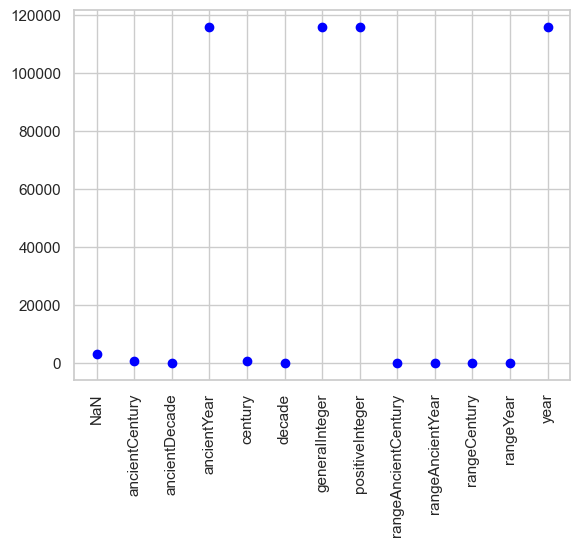

In [330]:
plt.xticks(rotation=90)
plt.plot(*zip(*sorted(histogram.items())),'bo')

With this information, we could improve our regular expressions from above or use other methods to clean-up the data.

### Inspecting Spatial Locations

Because the dataset contains a lot of historical works, the _spatial_ columns deserves further attention as we want to use it later for plotting geo-spatial locations. To get a feeling for the data, we will inspect its contents.

In [331]:
df.coverage.head(30)

0          Giessae Hessorum
1                  Marpurgi
2                   Leipsic
3                Glückstadt
4                    Berlin
5                    Berlin
6          Viennae Austriae
7                W Poznaniu
8                   Lipsiae
9                   Lipsiae
10                  Lipsiae
11                 Basileae
12                  Stettin
13                Rostochii
14                   Hallae
15                  Hamburg
16               Stendaliae
17                   [S.l.]
18                   [S.l.]
19                   [S.l.]
20                   [S.l.]
21                   [S.l.]
22                 [Bremen]
23                   [S.l.]
24                   [S.l.]
25                   [S.l.]
26                  Hamburg
27    Augustae Vindelicorum
28                     Prag
29                   [S.l.]
Name: coverage, dtype: object

Unfortunately, the spatial column does not only contain cities (or cities with their modern name).  Sometimes, more than one city or a even a country is contained. Another variant uses square brackets. Additionally, specific bibliographic terminology indicate that no place of publication ([s.l.]=sine loco=without place or o.O. as its German equivalent) could be determined.

### Non-Destructive Data Cleansing

Given the flaws of the inspected data, it is necessary to combine our findings into an automated process that will take the given data as input and create new columns with the cleaned results.

We will not override the old data as we might it later. Hence, our approach can be considered non-destructive as it only adds new (generated) information that we will use later to work with.

In [332]:
class DataCleaner:
    # matches alphanumeric character and the underscore at the beginning of the string
    #Unicode flag is needed because of Asian character sets otherwise such signs would be considered as non-alphanumeric
    regEx_AlphaNum=re.compile("^\w",re.UNICODE)
    # checks for surrounding []; will match almost everything but Asian characters
    regEx_BracketText=re.compile("^\[[\w\?\.,\sßÄäÖöÜü]*\]",re.UNICODE)
    # checks for typical spellings of the "sine loco" abbreviation "s. l."
    regEx_SineLoco=re.compile("[sSoO]\s?\.\s?[lLoO]\s?\.?\s?",re.UNICODE)
    
    def __init__(self):
        pass
    
    def cleanAncientYearStrict(self,readData):
        if type(readData)==float:
            if not readData:
                return 0
            else:
                return readData
        else:
            p=re.compile(patterns["ancientYear"])
            m = p.search(str(readData))
            if m:
                firstAppearance=m.group()
                return firstAppearance
            else:
                return np.nan
            
    def cleanSpatialText(self,readData):
        returnedString=""
        # just in case we did not get a string, we use brute force and return NaN
        if type(readData)==float:
            return ""
        else:
            #readData=str(readData)
            m = self.regEx_AlphaNum.search(readData)
            # if the string does start with a bracket...
            if not m:
                #print "No matches at all: "+row[1]["PPN"]+"\t for: "+str(readData)
                m2 = self.regEx_BracketText.search(readData)
                if m2:
                    matchedGroup=m2.group()
                    #print "\tMatch: "+matchedGroup
                    m3=self.regEx_SineLoco.search(matchedGroup)
                    if m3:
                        #print "\tMatched Sine Loco: "+str(m3.group())
                        return ""
                    else:
                        matchedGroup=matchedGroup.replace("[","").replace("]","")
                        #print "\tFinal string: "+matchedGroup
                        returnedString=matchedGroup
            # otherwise, it may still be a "sine loco"
            else:
                m3=self.regEx_SineLoco.search(readData)
                if m3:
                    #print "\tMatched Sine Loco: "+str(m3.group())
                    return ""
                else:
                    # in any case, there might be brackets left
                    returnedString=readData.replace("[","").replace("]","")
        
        # remove variants of "u.a."            
        regex = re.compile("[uU]\.\s?[aA]\.\s?",re.UNICODE)
        returnedString=regex.sub("",returnedString)
        return returnedString

In [333]:
dc=DataCleaner()

#for row in df.iterrows():
#    print dc.cleanSpatialText(str(row[1]["spatial"]))
    
df['spatialClean'] = df.coverage.apply(dc.cleanSpatialText)
df['dateClean'] = df.date.apply(dc.cleanAncientYearStrict)

Again, we will inspect our results.

In [334]:
df.head(30)

,title,creator,subject,publisher,type,format,identifier,language,date,coverage,rights,PPN,spatialClean,dateClean
0,"Collegium Ethicum, In Quo De Summo Hominis Bon...","Liebenthal, Christianus",Historische Drucke,Hampelius,monograph,application/mets+xml,PPN1000000974,lat,1620,Giessae Hessorum,Public Domain Mark 1.0,PPN1000000974,Giessae Hessorum,1620
1,"Augustini Niphi, Philosophi Suessani De Auguri...","Niphus, Augustinus",Historische Drucke,Egenolphus,monograph,application/mets+xml,PPN100000127X,lat,1614,Marpurgi,Public Domain Mark 1.0,PPN100000127X,Marpurgi,1614
2,Concerto pour la Flûte avec Accompagnement de ...,"Danzi, Franz",Musiknoten,Breitkopf & Härtel,monograph,application/mets+xml,PPN1000006808,NaN,1806,Leipsic,CC BY-NC-SA 4.0 International,PPN1000006808,Leipsic,1806
3,Schuldige Condolentz-Zeilen Womit seinem Gelie...,"Koltemann, Otto Benedict",Historische Drucke,Königliche privil. Buchdruckerey,monograph,application/mets+xml,PPN1000056597,ger,1719,Glückstadt,Public Domain Mark 1.0,PPN1000056597,Glückstadt,1719
4,Johann Friedrich Böttchers der Arzney und Wund...,"Böttcher, Johann Friedrich",Historische Drucke,Oehmigke,monograph,application/mets+xml,PPN1000059669,ger,1796,Berlin,Public Domain Mark 1.0,PPN1000059669,Berlin,1796
5,Vom Aktienwesen; eine geschäftliche Betrachtung,"Rathenau, Walther",Historische Drucke,S. Fischer-Verlag,monograph,application/mets+xml,PPN1000065081,ger,1917,Berlin,Public Domain Mark 1.0,PPN1000065081,Berlin,1917
6,"Iustus Et Aequus Iudex, Quem Post emensum legi...","Senutti, Wolffgangus Nicolaus Joannes",Historische Drucke,Schwendimann,monograph,application/mets+xml,PPN1000065707,lat,1716,Viennae Austriae,Public Domain Mark 1.0,PPN1000065707,Viennae Austriae,1716
7,Przewodnik dla Matki Chrzescijańskiéj we wycho...,"Cramer, Wilhelm",Historische Drucke,Nakładem Wydawnictwa Jim ks. Fr. Baźyńskiego (...,monograph,application/mets+xml,PPN1000067858,pol,1878,W Poznaniu,Public Domain Mark 1.0,PPN1000067858,W Poznaniu,1878
8,Disputatio Philologica De Synonymis Dei Hebrai...,"Friderici, Valentin",Historische Drucke,Wittigau,monograph,application/mets+xml,PPN1000074277,lat,1673,Lipsiae,Public Domain Mark 1.0,PPN1000074277,Lipsiae,1673
9,Exercitatio Philologica De voce šāmayîm Illust...,"Thym, Gottfried",Historische Drucke,Literis Colerianis,monograph,application/mets+xml,PPN1000076849,lat,1670,Lipsiae,Public Domain Mark 1.0,PPN1000076849,Lipsiae,1670


### Using Clustering for Further Data Cleansing

The approach used above, relying on regular expression, is very cumbersome when dealing with natural language such as locations. We will run into problems inspecting each record and writing down regular expressions. Thus, we can utilize cluster algorithms to lower the complexity of the inspection by "grouping" similar entries and to deal with them groupwise.

#### A Simple Scenario

To illustrate clustering, we first create our sample data and display it.

In [335]:
words = u'Berlin Balin Cölln Köln'.split()
print(words)

print("Number of words: %i" % len(words))
for i,val in enumerate(words):
    print(str(i)+":\t "+str(val.encode('utf-8')))
    

['Berlin', 'Balin', 'Cölln', 'Köln']
Number of words: 4
0:	 b'Berlin'
1:	 b'Balin'
2:	 b'C\xc3\xb6lln'
3:	 b'K\xc3\xb6ln'


To determine the similarity of entries that will be grouped later, we have to use a distance function working on strings. One possible choice is the Jaro distance function.

Then, we are interested in finding out whether the Jaro distance is really implemented as a distance. As you might remember from your studies, a (normalized) distance yields 1.0 for dissimilar object. Hence, the distance between "Berlin" and "Berlin" should be 0.

In [336]:
jaro_distance(u'Berlin',u'Berlin')

1.0

Obviously, it is not a distance as we expected 0 for the distance between "Berlin" and "Berlin" as it is the same string. Therefore, we have to subtract the future results of __jaro_distance()__ from 1.0 to get a real distance score.

In the next step, we create a triangle matrix with the indices from above.

In [337]:
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.triu_indices.html
# 2nd parameter:
# Diagonal above which to zero elements. k = 0 (the default) is the main diagonal, k < 0 is below it and k > 0 is above."""
# r= Return the indices for the upper-triangle of an (n, m) array. da m nicht angegeben ist, wird n=m angenommen
# m is not passed, hence m=n

# sagen, dass die matrix square ist!
r=np.triu_indices(n=len(words), k=1)
r

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))

The resulting triangle matrix can be read by referring to the indices of our sample data.
$$
A=
\begin{pmatrix}
a_{0,0} & \underline{a_{0,1}} & \underline{a_{0,2}} & \underline{a_{0,3}} \\
\cdot & a_{1,1} & \underline{a_{1,2}} & \underline{a_{1,3}} \\
\cdot & \cdot & a_{2,2} & \underline{a_{2,3}} \\
\cdot & \cdot & \cdot & a_{3,3}
\end{pmatrix}
$$

That is, $a_{0,1}$, stands for the difference between "Berlin" (index 0) and "Balin" (index 1). In other words:
$$
A=
\begin{pmatrix}
\mbox{Berlin, Berlin} & \underline{a_{0,1}} & \underline{a_{0,2}} & \underline{a_{0,3}} \\
\cdot & \mbox{Balin, Balin} & \underline{a_{1,2}} & \underline{a_{1,3}} \\
\cdot & \cdot & \mbox{Cölln, Cölln} & \underline{a_{2,3}} \\
\cdot & \cdot & \cdot & \mbox{Köln, Köln}
\end{pmatrix}
$$

To calculate the distance between the different terms represented by the triangle matrix, we have to provide a distance function that will be applied to each term pairs.

In [338]:
def d_demo(coord):
    print(coord)
    i, j = coord
    # the distance fix we have learnt about before...
    return 1-jaro_distance(words[i], words[j])

In [339]:
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.set_printoptions.html
np.set_printoptions(precision=4)

# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(d_demo, 0, r)
r2

[0 1]
[0 2]
[0 3]
[1 2]
[1 3]
[2 3]


array([0.1778, 0.4222, 0.3889, 0.4   , 0.3667, 0.2167])

The resulting array contains the values of the triangle matrix:
$$
A=
\begin{pmatrix}
a_{0,0} & \underline{0.1778} & \underline{0.4222} & \underline{0.3889} \\
\cdot & a_{1,1} & \underline{0.4} & \underline{0.3667} \\
\cdot & \cdot & a_{2,2} & \underline{0.2167} \\
\cdot & \cdot & \cdot & a_{3,3}
\end{pmatrix}
$$

That is, $a_{0,1}$, shows that the difference between "Berlin" and "Balin" is 0.17777778.

The elements on the diagonal are left out for good reason because we can safely assume that the difference between the same terms will be 0 using our difference function.

#### Clustering with Real Data

Again, we have to define the distance function first and construct a triangle matrix in accordance with our real data.

In [340]:
def d(coord):
    #print(coord)
    i, j = coord
    #py27 return 1-jaro_distance(unicode(str(words[i]), 'utf-8'), unicode(str(words[j]), 'utf-8'))
    return 1-jaro_distance(words[i],words[j])

In [341]:
df3=df

uniqueSpatials=df3["spatialClean"].unique()
words=None
if demoClustering:
    words=uniqueSpatials[:100] # only consider the first 100 elements for performance reasons
else: # during normal operation, we want to consider all unique spatial names...
    words=uniqueSpatials
r=np.triu_indices(len(words), 1)

The next step will take some time, hence we have limited the number of spatial labels before in demo mode.

In [342]:
printLog("Started calculation of distance matrix for %i words..."%len(words))
# _ is the last evaluated value in an interactive shell
# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(d, 0, r)
printLog("Finished calculations.")

[2023-01-01 17:28:09.753197]	Started calculation of distance matrix for 5063 words...
[2023-01-01 17:28:42.580707]	Finished calculations.


agglomeratives Clustering (hier nearest points, bottum-up) im gegensatz zu divisiven (top-down), das Beispiel hier nutzt den nearest point algorithm (Formel siehe https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html)

In [343]:
Z=scipycluster.linkage(r2)

if not demoClustering:
    pickle.dump( Z, open( "cluster_hierarchy_linkage_result_without_name_clustering.pickle", "wb" ) )

#Z
# scientific notation erklären

i müsste Zeile sein

A 4 by (n-1) matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

mehr infos: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/


In [344]:
#Z=pickle.load( open( "cluster_hierarchy_linkage_result.pickle", "rb" ) )
if demoClustering:
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
    )
    plt.show()

To work with the hierarchical clusters, we have to flatten them. Here, we rely on the distance and a heuristically chose value of 0.1.

In [345]:
clusters=scipycluster.fcluster(Z, t=0.1,criterion="distance")
# 2. parameter ist abhängig von der clustering strategie, -> cophenetic distance
# see: http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html
# An array of length n. T[i] is the flat cluster number to which original observation i belongs.


# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/cophenetic.html
# https://en.wikipedia.org/wiki/Cophenetic
# wir erhalten für jedes unser elemente eine cluster ID
clusters

array([1254, 2083, 2186, ..., 2389, 2352, 3105], dtype=int32)

The obtained cluster are not meant to be used directly by humans.

Hence, we create service functions that help to establish a linkage between the cluster IDs and human readable names.

In [346]:
def getWordIndex(word):
    return np.where(words==word)[0]

def getClusterID(data):
#for row in df3.iterrows():
    #data=row[1]["spatialClean"]
    #wordIndex=np.where(words==data)[0]
    #if data == u"奈良".encode('utf-8'):
    #    print "China!"
    #    wordIndex=getWordIndex(data)
    #    print wordIndex
    #    print clusters[wordIndex][0]
    wordIndex=getWordIndex(data)
    if wordIndex:
        return clusters[wordIndex][0]
    else:
        return ""

### Inspecting the Clustered Results Deeper

In [347]:
#
Z_huge=pickle.load( open( "cluster_hierarchy_linkage_result_without_name_clustering.pickle", "rb" ) )
uniqueSpatials=df3["spatialClean"].unique()
words=uniqueSpatials
print("Unique spatial names: ",len(words))

Unique spatial names:  5063


In [348]:
clusters=scipycluster.fcluster(Z_huge, t=0.07,criterion="distance")

In the next cell, we will add a new column _spatialCluster_ to the dataframe to add its cluster ID.

In [349]:
df3['spatialCluster'] = df3["spatialClean"].apply(getClusterID)
grp=df3.groupby("spatialCluster")
#print grp.groups.keys()
print("Number of clusters: %i" % len(grp.groups.keys()))

Number of clusters: 3990


To get an impression of our clustering's quality, we will inspect some sample clusters.

In [350]:
grp.get_group(clusters[getWordIndex("Berlin")][0])

,title,creator,subject,publisher,type,format,identifier,language,date,coverage,rights,PPN,spatialClean,dateClean,spatialCluster
4,Johann Friedrich Böttchers der Arzney und Wund...,"Böttcher, Johann Friedrich",Historische Drucke,Oehmigke,monograph,application/mets+xml,PPN1000059669,ger,1796,Berlin,Public Domain Mark 1.0,PPN1000059669,Berlin,1796,2257
5,Vom Aktienwesen; eine geschäftliche Betrachtung,"Rathenau, Walther",Historische Drucke,S. Fischer-Verlag,monograph,application/mets+xml,PPN1000065081,ger,1917,Berlin,Public Domain Mark 1.0,PPN1000065081,Berlin,1917,2257
33,Lucas Cranach's Stammbuch; enthaltend die von ...,"Mechel, Christian",Historische Drucke,Herausgeber,monograph,application/mets+xml,PPN1000100669,ger,1814,Berlin,Public Domain Mark 1.0,PPN1000100669,Berlin,1814,2257
70,"Kurtze Anweisung, wie mit Säung des Maulbeer-S...",NaN,Historische Drucke,Gäbert,monograph,application/mets+xml,PPN1000492249,ger,1750,Berlin,Public Domain Mark 1.0,PPN1000492249,Berlin,1750,2257
71,Gesundheitskatechismus für das Landvolk und de...,"Senfft, Adam Andreas",Historische Drucke,Nicolai,monograph,application/mets+xml,PPN1000493849,ger,1781,Berlin,Public Domain Mark 1.0,PPN1000493849,Berlin,1781,2257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119911,Brief von Adelbert von Chamisso an Antonie von...,"Chamisso, Adelbert von",Nachlässe und Autographe,NaN,manuscript,application/mets+xml,PPN739744887,de,1826,Berlin,NaN,PPN739744887,Berlin,1826,2257
119913,Bürgerglück; Lustspiel in drei Aufzügen,"Babo, Joseph Marius",Historische Drucke,Voss,monograph,application/mets+xml,PPN739744909,ger,1792,Berlin,Public Domain Mark 1.0,PPN739744909,Berlin,1792,2257
119943,Brief von Adelbert von Chamisso an Antonie von...,"Chamisso, Adelbert von",Nachlässe und Autographe,NaN,manuscript,application/mets+xml,PPN739745409,de,1834,Berlin,NaN,PPN739745409,Berlin,1834,2257
119961,Brief von ... de Gensan (preußischer General) ...,"Gensan, ... de",Nachlässe und Autographe,NaN,manuscript,application/mets+xml,PPN739745697,fr,1802,Berlin,NaN,PPN739745697,Berlin,1802,2257


The next cell is a shortcut, selecting only the unique names within a cluster...

In [352]:
grp.get_group(clusters[getWordIndex("Frankfurt/Oder")][0])["spatialClean"].unique()

array(['Frankfurt, Main', 'Frankfurt/Main', 'Frankfurt am Mayn',
       'Frankfurt am Main', 'Frankfurt/Oder', 'Franckfurt am Meyn',
       'Franckfurt am Mayn', 'Franckfurt, Main', 'Frankfurt, Maín',
       'Franckfurt am Mäyn', 'Franfurt am Main', 'Frankfurt a.M.',
       'Frankfurt (Oder)', 'Franckfort am Mayn', 'Frankfurt a. M.',
       'Frankfurt a/M', 'Frankfurt, Oder', 'Frankfurt., Main',
       'Frankfurt m Main', 'Frankfurt a. Main', 'Frankfurt amMain',
       'Franckfurth am Mäyn', 'Franckfurth am Mayn', 'Frankfurt a/O',
       'Frankfurt-Oder', 'Frankfurt a.M', 'Frankfurt a. M',
       'Frankfurt a./m.', 'Frankfurt a/M.', 'Frankfurth a.d.O.',
       'Frankfurt a/O.', 'Frankfurt a.O.', 'Frankfurt a.d.O.',
       'Frankfurth a/O', 'Frankfurt am Main?', 'Frankfurt a. Oder',
       'Frankfurt a. O.', 'Frankfurt a.  M.', 'Franckfurt a.M.',
       'Franckfurt am Main', 'Frankfurt a. d. Oder', 'Frankfurt a. M. ',
       'Franckfurt a.O.', 'Frankfurta a.M.', 'Frankfurt a. d. O.',
  

Obviously, the contents of the cluster are semantically incorrect. However, the strings resemble each other. The clustering approach is limited in our scenario.

Nevertheless, we can inspect all other clusters' contents.

In [360]:
for key in grp.groups.keys():
    if key:
        print(key)
        print(grp.get_group(key)["spatialClean"].unique())

1
['内府刻本']
2
['補刻本']
3
['晦明軒']
4
['四明鮑氏']
5
['和歌山']
6
['天台山']
7
['蜀南桐華書屋']
8
['蜀南薛氏桐華書屋']
9
['長崎']
10
['高崎']
11
['長岡']
12
['湖北']
13
['湖南']
14
['臺北']
15
['濟南']
16
['伊勢国津']
17
['伊勢']
18
['武昌']
19
['武甯']
20
['武英殿']
21
['禪山']
22
['佛山']
23
['虞山']
24
['竹韻山房 藏']
25
['紅店山房藏板']
26
['金陵']
27
['金陵書局']
28
['尚義堂 重刊']
29
['輔仁堂 刊']
30
['荊州 : 荊州駐防繙譯總學']
31
['荊州']
32
['廣州']
33
['廣州海幢寺經坊 藏板']
34
['紹義堂 藏版']
35
['義善堂 藏版']
36
['寳章堂 藏版']
37
['玉堂']
38
['玉勾草堂 藏版']
39
['振賢堂梓行' '振賢堂 梓行']
40
['文畬堂藏板']
41
['德文堂藏板']
42
['聚文堂藏板']
43
['貴文堂 藏板']
44
['來鹿堂 藏板']
45
['廣慶堂 藏板']
46
['春暉堂 藏板']
47
['積秀堂 藏板']
48
['振賢堂 藏板']
49
['敬書堂 梓行']
50
['太和堂 藏板']
51
['墨華堂梓行']
52
['文盛堂藏版']
53
['三槐堂藏版']
54
['元新堂藏板']
55
['經國堂藏板']
56
['遠源堂藏版']
57
['近譬堂 梓']
58
['一經堂']
59
['山東']
60
['山東書局']
61
['廣東嘉應州']
62
['廣東']
63
['杭州']
64
['秣陵']
65
['金閶']
66
['藝蘭圃 藏板']
67
['涵遠齋 梓行']
68
['敬義齋 藏板']
69
['集腋軒 藏版']
70
['榮華堂 存板']
71
['柏林寺 存板']
72
['汲古閣 藏版']
73
['星州']
74
['星沙']
75
['灌文書社 印行']
76
['醉經樓書坊梓行']
77
['本衙藏板']
78
['椒華吟舫藏板']
79
['廣雅書局 刻']
80
['書業堂鐫藏']
81
[

['Unterach']
860
['Utrecht']
861
['Utrecht: Honig']
862
['Ultrajecti']
863
['Andernach']
864
['Utrecht ermittelt']
865
['Abdera']
866
['Andermatt']
867
['Cahla']
868
['Clapham']
869
['Calais']
870
['Capebam']
871
['Toskana' 'Toskana?']
872
['Koblenz' 'Koblenz ']
873
['Coblenz' 'Coblentz']
874
['Firenze']
875
['Florenz']
876
['Filehne']
877
['Embdae' 'Emdae']
878
['Embden' 'Emden' 'Eden']
879
["T'Embden"]
880
['Coloniae Agrippinae' 'Colonia Agrippina']
881
['Coloniae Munatianae']
882
['Coloniae Plancianae']
883
['Coloniae Marchicae']
884
['Coloniae Ad Spream']
885
['Colonia ad Spream']
886
['Coloniae cis Spream']
887
['Coloniae ad Spream']
888
['Coloniae' 'Colonia']
889
['Cologne']
890
['A Cologne']
891
['Boulogne']
892
['Bologna']
893
['Coloniae Brandenburgicae' 'Coloniae Brandeburgicae']
894
['Coloniae Brandenb.' 'Coloniae Brand.']
895
['Coloniæ Brandenburgicæ']
896
['Colon. Brandenb.']
897
['Boulogne-sur-Mer']
898
['Colonia i.e. Lucca']
899
['Cologne fingiert?']
900
['Offenbach sur l

1382
['Monaco ermittelt']
1383
['London ermittelt']
1384
['Dresden-Wachwitz']
1385
['Dresden-Blasewitz']
1386
['Viennae Austriae' "Vienna d'Austria" "Vienna d' Austria"
 "Vienna D'Austria" 'Vienna Austriae' "Vienna d' Avstria"]
1387
['Vienne En Autriche']
1388
['Giessae-Hassorum' 'Giessae Hassorum' 'Gissae Hassorum' 'Gissae-Hassorum']
1389
['Giessae Cattorum']
1390
['Fredericia']
1391
['Fridericia']
1392
['Friedrichshafen' 'Friedrichshagen']
1393
['Friedrichsdorf']
1394
['Friedrichroda']
1395
['Friedrichroda i. Th.']
1396
['Friedrichsdorf, Taunus']
1397
['Friedrichsruh']
1398
['Friedrichshagen bei Berlin']
1399
['Fiedrichshütte']
1400
['Friedrichshütte ']
1401
['Friedrichstadt']
1402
['Fridericostadii']
1403
['Friedrichshütte, Göttingen, ']
1404
['Heinrichstadt']
1405
['Striegau' 'Striegau ']
1406
['In Strigau']
1407
['Paderborn' 'Paderbornae' 'Paderborn ']
1408
['Herborn']
1409
['Herbornae']
1410
['Paderborn Schöningh']
1411
['Herbornae Nassoviorum']
1412
['Herbornae Nassauiorum']
141

2132
['München' 'München ' 'München?']
2133
['München-Gern']
2134
['Jüchen']
2135
['U Tubingi']
2136
['Münster (Westfalen)']
2137
['Münster (Westf)']
2138
['Münster <Westfalen>']
2139
['Münster' 'Münster ']
2140
['Munster']
2141
['Münster i. W.' 'Münster i.W.']
2142
['Münster i. Westf.']
2143
['Münster in Westfalen' 'Münster in Westphalen']
2144
['Münster in Westf.']
2145
['Munsterlager']
2146
['Monasterii Westphaliae']
2147
['Halle-Saale' 'Halle/Saale']
2148
['Halle (Saale)' 'Halle(Saale)']
2149
['Halle, Saale']
2150
['Halle <Saale>']
2151
['Haarlem' 'Haarlem ' 'Harlem']
2152
['Hamm' 'Hamm ']
2153
['Hamm i.W.' 'Hamm i. W.']
2154
['Hamm i. Westf.']
2155
['Hallae' 'Halle' 'Halae' 'Hall' 'Halle?' 'Halla' 'Halle ']
2156
['Hal']
2157
['Hali']
2158
['Halæ']
2159
['Halle/S.' 'Halle a/S.']
2160
['Calbe a. d. S.' 'Calbe a. d. S']
2161
['Halle a. S.' 'Halle a.S.']
2162
['Halle a.d.S.' 'Halle a. d. S.']
2163
['Halle a / d. S.']
2164
['Halle a. d. Saale']
2165
['Hagen i. Westf.' 'Hagen i.Westf.']

['Dahlem <Berlin>']
2877
['Farciennes']
2878
['Rintelii ad Visurgim']
2879
['Rigi First']
2880
['Mainz und Paris']
2881
['Landscheid']
2882
['Stargard Szczeciński']
2883
['Eberbach im Rheingau']
2884
['Köln-Deutz']
2885
['Igls']
2886
['Beverstedt']
2887
['Neustadt in Holstein']
2888
['Middelburg : van der Gijp']
2889
['Schloss Lindenberg']
2890
['Warschau i.e. Berlin']
2891
['Rees']
2892
['Wahn']
2893
['Paddington']
2894
['Sankt Ingbert']
2895
['Deutschland (z. T. Magdeburg)']
2896
['Gartz (Oder)']
2897
['Berlin-Grosslichterfelde-W.']
2898
['Mohrungen u. Königsberg']
2899
['Wermelskirchen']
2900
['W Elbiągu']
2901
['Hottingen-Zürich']
2902
['Barcelona']
2903
['Ljubljana']
2904
['Lippstadt']
2905
['Ceylon']
2906
['Wetzig']
2907
['Jülich']
2908
['Unterseen']
2909
['Olsztynek']
2910
['Elbląg']
2911
['Albury']
2912
['Darkehmen']
2913
['Leuven']
2914
['Santander']
2915
['Winzig']
2916
['Rimini']
2917
['Heilbad Heiligenstadt']
2918
['Rustolstadt']
2919
['Bad Griesbach']
2920
['Wien-Grinzing'

['Vittel <Region>']
3532
['Handschuhsheim / Heidelberg']
3533
['Unterkralowitz']
3534
['Riva del Garda']
3535
['Benediktbeuern']
3536
['Neudamm']
3537
['Kilchberg-Zürich']
3538
['Mieders im Stubaital']
3539
['Scharfling am Mondsee']
3540
['Orthodoxiopel']
3541
['Manila, Philippine Islands']
3542
['Höchst']
3543
['Boppard']
3544
['Schweizermühle <Rosenthal-Bielatal>']
3545
['Wolkersdorf im Weinviertel']
3546
['Bad Freienwalde (Oder)']
3547
['Allendorf an der Werra']
3548
['Flöha i. S.']
3549
['Siemensstadt b. Berlin']
3550
['Certaldo/Italien']
3551
['Haaseloff in Weitland']
3552
['Heyligenstadt in Eichsfeld']
3553
['Ebenezer']
3554
['Saamaaranch']
3555
['Culm an der Weichsel']
3556
['Karlshorst bei Berlin']
3557
['Jerez de la Frontera']
3558
['Clarens <Montreux>']
3559
['Ingelheim-Ober-Ingelheim']
3560
['Horn bei Rorschach']
3561
['Reesewitz bei Oels']
3562
['Mandal (Vest-Agder)']
3563
['Baden-Baden ermittelt in der Vorlage: "Montebello"']
3564
['Francofurti in Electoratu Brandenburgico

* synonym: ['Francofurti Ad Viadrum'] as a Latin translation of Frankfurt/Oder would be long to the cluster with ['Frankfurt/Main' 'Frankfurt/Oder' 'Frankfurt, Main' 'Frankfurt, O']
* however, Frankfurt/Main and Frankfurt/Oder are to differt cities
* ['Francofurti'] is in a 1-element cluster
* ['C\xc3\xb6lln an der Spree'] is a synonym for Berlin
* duplicate entries: ['Hallae Magdeburgicae  Hallae Magdeburgicae'] 1-gram und 2-gram vergleichen!
* auf Enthaltensein von Berlin prüfen
* St. Sankt Saint Bad als Präfix behandeln

In [361]:
# backup of the dataframe as we are going to remove data from the spatialClean column
pickleCompress('./picklez/df3_unclean_spatials.picklez',df3)

[2023-01-01 17:40:30.614649]	Pickling to './picklez/df3_unclean_spatials.picklez'
[2023-01-01 17:40:34.282805]	Pickling done.


### Further Cleansing of Multiple City and Compound Names

As the examples seen before clearly illustrate, dealing with location names is a rather complex issue.
For instance, on some occasions, we have to deal with _spatialClean_ entries that contain multiple cities or locations as seen below.

In [190]:
# if you want to continue from here, uncomment the following line
#df3=pickleDecompress('./picklez/df3_unclean_spatials.picklez')

In [365]:
# PPN771806655 contains multiple cities (please note that this might have changed after 2021/06/12 in case the library has revised its records)
df3[df3.PPN=="PPN1000000974"]

,title,creator,subject,publisher,type,format,identifier,language,date,coverage,rights,PPN,spatialClean,dateClean,spatialCluster
0,"Collegium Ethicum, In Quo De Summo Hominis Bon...","Liebenthal, Christianus",Historische Drucke,Hampelius,monograph,application/mets+xml,PPN1000000974,lat,1620,Giessae Hessorum,Public Domain Mark 1.0,PPN1000000974,Giessae Hessorum,1620,


It is safe to assume that location names can occur in various forms. Hence we load a look-up list of existing city names for later use.

To avoid superfluous comparisons we split the city names by their leading character and save them to a dictionary with the leading character as key.

* https://www.maxmind.com/en/free-world-cities-database
* http://www.geonames.org/export/
* http://www.opengeocode.org/download.php#cities
* https://en.wikipedia.org/wiki/Lists_of_cities_by_country


In [192]:
cityNameFile_DE = open('citynames.txt', 'r')
cityNGramsDE=dict()
lastLetter=""
for line in cityNameFile_DE:
    if not line.startswith("//"):
        r=line.replace("\n","").strip()
        if " " in r:
            #print r
            if not lastLetter==r[0].lower():
                lastLetter=r[0].lower()
                cityNGramsDE[lastLetter]=[]
            cityNGramsDE[lastLetter].append(r)
            #py27 cityNGramsDE[lastLetter].append(r.decode("utf-8"))

In this scenario, we will simplify the handling of location names, i.e., in case of multiple cities, we will only consider the first one. Furthermore, we will check for known (compound) city names in our recently loaded database. If we find a city name there, we will use it instead of splitting up the string.

Obviously, this approach is far from being perfect but some test case will illustrate the idea.

In [193]:
# Various test cases of city names
test_strings=[]
test_strings.append("Frankfurt, O")
test_strings.append('Hallae Magdeburgicae  Hallae Magdeburgicae')
test_strings.append("Leipzig  Paris  Petersburg  London")
test_strings.append('Franckfurt  N\xc3\xbcrnberg  Leipzig')
test_strings.append('Frankfurt/Main') 
test_strings.append('Frankfurt, Main')
test_strings.append('Bad Nauheim')
test_strings.append('Rottach-Egern am Tegernsee')
test_strings.append('Egern a. Tegernsee')
test_strings.append("Plancy-L'Abbaye")
test_strings.append('Bad Nauheim Sankt')
test_strings.append("Saint Tropez")
test_strings.append("Sankt Augustin")
test_strings.append("Sankt-Augustin")
test_strings.append("St. Whatever")
test_strings.append("Berlin Oberschöneweide")


def pickFirstCity(testString):
# checks if the testString contains multiple cities separated by whitespaces and returns the first city respecting city name prefixes such as Saint, St. etc.
    
    # matches for whitespaces that are NOT preceded by the following signs: ", ; : \ / " denoted in the regex by (?<!...)
    regex = re.compile("(?<![,;:\\\/])\s*\s",re.UNICODE)
    regex2 = re.compile("(?<![,;:\\\/])\s*",re.UNICODE)

    # matches various city prefix such as Saint etc.
    spatialPrefixRegExes=[]
    spatialPrefixRegExes.append(re.compile("^[Bb][Aa][Dd]\s*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[Ss][Aa][Nn][Kk][Tt][\s-]*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[Ss][Aa][Ii][Nn][Tt][\s-]*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[S][t]\.[\s-]*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[Dd][Ee][Nn]\s*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[Ne][Ee][Ww]\s*",re.UNICODE))

    #print "Tested string: >%s<" % testString
    
    if allowExactStringMatching:
        # checks whether the spatial is known to consist of more than one word
        # for the sake of efficiency we will only check for spatial names with the same leading character (see above)
        lowTestString=testString.lower()
        if len(lowTestString)>=1:
            currentLetter=lowTestString[0]
            if currentLetter in cityNGramsDE:
                for cityName in cityNGramsDE[currentLetter]:
                    foundIndex=lowTestString.find(cityName.lower())
                    #regexCity = re.compile("^\b"+cityName.lower()+"\b",re.UNICODE)
                    r=re.match("\\b"+cityName.lower()+"\\b",lowTestString)
                    #if foundIndex==0:
                    if r is not None:
                        #print "Compound city: "+cityName+" @ "+str(foundIndex)
                        return cityName
    
    # if the string is not splitable by spaces skip futher processing
    if len(testString.split(" "))<2:
        return testString
        
    # general purpose splitting
    foundSpatialPrefix=False
    for i,r in enumerate(spatialPrefixRegExes):
        m = r.search(testString)
        if m:
            #print "Prefix %i" %i
            foundSpatialPrefix=True
            #print("Spatial prefix form %i to %i"%(m.start(),m.end()))
    #print type(testString)
    
    t=regex.search(testString)
    #if t:
    #    print("\tTesting for separator: %i - %i"%(t.start(),t.end()))
    m = regex.split(testString)
    #m = regex.search(testString)
    #print(m)
    
    if foundSpatialPrefix:
        #print("spatial prefix")
        if len(m)>1:
            return m[0]+" "+m[1]
    else:
        if m:
            return m[0]
        else:
            return testString

for cities in test_strings:
    print("First pick for >%s<: %s"%(cities,pickFirstCity(cities)))   

First pick for >Frankfurt, O<: Frankfurt, O
First pick for >Hallae Magdeburgicae  Hallae Magdeburgicae<: Hallae
First pick for >Leipzig  Paris  Petersburg  London<: Leipzig
First pick for >Franckfurt  NÃ¼rnberg  Leipzig<: Franckfurt
First pick for >Frankfurt/Main<: Frankfurt/Main
First pick for >Frankfurt, Main<: Frankfurt, Main
First pick for >Bad Nauheim<: Bad Nauheim
First pick for >Rottach-Egern am Tegernsee<: Rottach-Egern am Tegernsee
First pick for >Egern a. Tegernsee<: Egern
First pick for >Plancy-L'Abbaye<: Plancy-L'Abbaye
First pick for >Bad Nauheim Sankt<: Bad Nauheim
First pick for >Saint Tropez<: Saint Tropez
First pick for >Sankt Augustin<: Sankt Augustin
First pick for >Sankt-Augustin<: Sankt-Augustin
First pick for >St. Whatever<: St. Whatever
First pick for >Berlin Oberschöneweide<: Berlin


As we plan to overwrite the _spatialClean_ column of each record, we will save the complete data externally if we need it later.

In [194]:
counter=0
maxItems=df3.shape[0]

multipleCitiesPPN=dict()

printLog("Processing multiple spatial names entries...")
for row in df3.iterrows():
    ppn=str(row[1]["PPN"])  
    spatialC=str(row[1]["spatialClean"])
    multipleCitiesPPN[ppn]=[]
    
    counter=counter+1
    if counter%10000==0:
        printLog("\tProcessed %i items of %i"%(counter,maxItems))
                
    if spatialC:
        origSpatialClean="<"+spatialC+"> ("+ppn+")"
        f=pickFirstCity(spatialC)
        loopCount=1
        while f:
            #print f
            multipleCitiesPPN[ppn].append(f)
            #py27 spatialC=spatialC.decode("utf-8")
            spatialC=re.sub('\s+',' ',spatialC.replace(f,u"")).strip()
            #py27 spatialC=spatialC.encode("utf-8")
            if spatialC:
                #print "<"+f.encode("utf-8")+"> | <"+spatialC+">"
                #f=spatialC
                f=pickFirstCity(spatialC)
            else:
                #print origSpatialClean
                break
            loopCount=loopCount+1
            if loopCount>15:
                printLog("Max. loop count reached @ "+origSpatialClean+ " with last f of: <"+f+">")
                break
        #if f:
            #spatialC=spatialC.decode("utf-8")
            #spatialC=spatialC.replace(f,u"").strip()
            #spatialC=spatialC.encode("utf-8")
            #if spatialC:
                #print origSpatialClean
                #print "<"+f.encode("utf-8")+"> | <"+spatialC+">"
                #counter=counter+1
                #if counter==10:
                    #break
    #print ppn
    #break
printLog("Done.")
pickleCompress("./picklez/multipleSpatialNamesPerPPN.picklez",multipleCitiesPPN)

[2022-12-30 19:25:38.004747]	Processing multiple spatial names entries...
[2022-12-30 19:25:38.490319]		Processed 10000 items of 120000
[2022-12-30 19:25:38.993588]		Processed 20000 items of 120000
[2022-12-30 19:25:39.512293]		Processed 30000 items of 120000
[2022-12-30 19:25:39.988900]		Processed 40000 items of 120000
[2022-12-30 19:25:40.568684]		Processed 50000 items of 120000
[2022-12-30 19:25:41.063219]		Processed 60000 items of 120000
[2022-12-30 19:25:41.654851]		Processed 70000 items of 120000
[2022-12-30 19:25:42.122947]		Processed 80000 items of 120000
[2022-12-30 19:25:42.685484]		Processed 90000 items of 120000
[2022-12-30 19:25:43.245096]		Processed 100000 items of 120000
[2022-12-30 19:25:43.815344]		Processed 110000 items of 120000
[2022-12-30 19:25:44.386799]		Processed 120000 items of 120000
[2022-12-30 19:25:44.387163]	Done.
[2022-12-30 19:25:44.387348]	Pickling to './picklez/multipleSpatialNamesPerPPN.picklez'
[2022-12-30 19:25:44.756435]	Pickling done.


Next, we display the PPNs with multiple spatial names to check whether the only contain locations. If not we should feedback this information to our algorithm sketched above. For the sake of brevity, we will skip the (necessary) step here.

In [369]:
for ppn in multipleCitiesPPN:
    array=multipleCitiesPPN[ppn]
    if len(array)>1:
        print(ppn+":\t"+"; ".join(array))

PPN1000000974:	Giessae; Hessorum
PPN1000065707:	Viennae; Austriae
PPN1000067858:	W; Poznaniu
PPN1000087425:	Augustae; Vindelicorum
PPN1000092038:	Stadt; am; Hof
PPN1000295044:	W; Elbiągu
PPN1000487318:	Francofurti; ad; Virum
PPN1000749290:	S.; Peterburg
PPN1000750450:	Stettin; : Möller, Martin
PPN1000766365:	Francofurti; ad; Virum
PPN1000794660:	Erscheinungsort; nicht; ermittelbar
PPN1000795403:	Erscheinungsort; nicht; ermittelbar
PPN1000933407:	Klein; Räschen
PPN1000983331:	Francofurti; ad; Virum
PPN1001008774:	Düßburg; ahm; Rhein
PPN1001055942:	Leipzig; u.; Winterthur
PPN1001056183:	Leipzig; u.; Winterthur
PPN1001412044:	Neustadt; Magdeburg
PPN1001416848:	Rotenburg; an; der; Fulde
PPN1001678230:	Frankfurt; am; Mayn
PPN1001680448:	Halae; Magdeburgicae
PPN1002240824:	Offenbach; sur; le; Mein
PPN1002295017:	Marburgi; Cattorum
PPN1002337410:	Francofurti; ad; Moenum
PPN100252332X:	Norditalien; -; Lombardei
PPN1002553172:	Nürnberg; ; Bamberg; ; Würzburg; ; Ansbach; ; Nördlingen; ; Regensbu

PPN1682547000:	京城; 서울
PPN1682548120:	京城; 서울
PPN1682548260:	京城; 서울
PPN1682548384:	京城; 서울
PPN1682548546:	京城; 서울
PPN1682548872:	京城; 서울
PPN1682549038:	京城; 서울
PPN1682549151:	京城; 서울
PPN1682549925:	京城; 서울
PPN168255015X:	京城; 서울
PPN1682550303:	京城; 서울
PPN1682550389:	京城; 서울
PPN1682550427:	京城; 서울
PPN1682550478:	京城; 서울
PPN1683336348:	Erscheinungsort; nicht; ermittelbar
PPN1683339347:	Gartz; (Oder)
PPN1683355768:	A; Berlin
PPN1683363450:	Ohne; Ort
PPN1683366891:	Ohne; Ort
PPN1683368452:	Müllheim; TG
PPN168337195X:	Baden-Württemberg (Kreis; Emmendingen)
PPN1683376374:	In; Rinteln
PPN1683376811:	Beuthen; O.-S.
PPN1683550617:	Frankfurt; (Oder)
PPN1683554957:	Ohne; Ort
PPN1683556852:	Halle; (Saale)
PPN1683557182:	Ohne; Ort
PPN1683557735:	Ohne; Ort
PPN1683640209:	Halle; (Saale)
PPN1683641914:	Halle; (Saale)
PPN168364221X:	VIII, 160; Seiten
PPN1683676238:	Erscheinungsort; nicht; ermittelbar
PPN1683697944:	Erscheinungsort; nicht; ermittelbar
PPN1683707400:	Erscheinungsort; nicht; ermittelbar
PPN1683710002:

PPN1806958236:	Osowa; Sień
PPN1806958252:	Osowa; Sień
PPN1806958295:	Osowa; Sień
PPN1806958317:	Osowa; Sień
PPN1806958325:	Osowa; Sień
PPN1806958341:	Osowa; Sień
PPN1806958376:	Osowa; Sień
PPN1806958384:	Osowa; Sień
PPN1806958406:	Osowa; Sień
PPN1806958422:	Osowa; Sień
PPN1806958449:	Osowa; Sień
PPN1806958457:	Osowa; Sień
PPN1806958473:	Osowa; Sień
PPN1806958503:	Osowa; Sień
PPN1806958511:	Osowa; Sień
PPN1806958562:	Osowa; Sień
PPN1806958597:	Osowa; Sień
PPN1806958619:	Osowa; Sień
PPN1806958627:	Osowa; Sień
PPN1806958651:	Osowa; Sień
PPN1806958716:	Osowa; Sień
PPN1806958740:	Osowa; Sień
PPN1806958767:	Osowa; Sień
PPN1806958783:	Osowa; Sień
PPN1806959089:	Osowa; Sień
PPN1806959119:	Osowa; Sień
PPN1806959127:	Osowa; Sień
PPN180695916X:	Osowa; Sień
PPN1806959240:	Osowa; Sień
PPN1806959267:	Osowa; Sień
PPN1806959305:	Osowa; Sień
PPN180695933X:	Osowa; Sień
PPN1806959356:	Osowa; Sień
PPN1806959380:	Osowa; Sień
PPN1806959402:	Osowa; Sień
PPN1806959437:	Osowa; Sień
PPN180695947X:	Osowa; Sień
P

PPN672746255:	Franckfurth; an; der; O
PPN67274774X:	Halle; im; Magdeburg.
PPN672987120:	Kiliae; Holsatorum
PPN67298749X:	Kiliae; Holsatorum
PPN673001156:	Halle; a.; S.
PPN673022021:	Lissa; i.; P.
PPN673074668:	Herbornae; Nassauiorum
PPN67308289X:	Cölln; an; der; Spree
PPN673084647:	Cölln; an; der; Spree
PPN673088677:	Cölln; an; der; Spree
PPN673089282:	Cölln; an; der; Spree
PPN673090043:	Coloniae; Brandenburgicae
PPN673095142:	Dortmund; Köppen
PPN673097277:	Cölln; an; der; Spree
PPN673100413:	Cölln; an; der; Spree
PPN673101819:	Franckfurt; an; der; O
PPN673104028:	Franckfurt; an; der; O
PPN673106802:	Cölln; an; der; Spree
PPN674653238:	Cölln; an; der; Spree
PPN674659589:	Cölln; an; der; Spree
PPN675459540:	Duisburgi; ad; Rhenum
PPN675466261:	Hersfeld; an; der; Fulda
PPN675796814:	Duisburgi; Ad; Rhenum
PPN675803349:	Schwerin; i.; Mecklb.
PPN675810280:	Cölln; an; der; Spree
PPN67582950X:	Frankfurt; a.M.
PPN675838738:	Veste; Cüstrin
PPN67585041X:	Franckf.; an; der; O
PPN675850568:	Franckf

(TODO)

* interessante PPN: PPN780104447; PPN771083963; PPN792355296; PPN735012342
* Umgang mit ? klären
* Einträge des Arrays übeprüfen: Propositionen (auch Mehrwerte-Komposita wie "an der"), Nicht-Ortsnamen (z.B. Poststempel)

Finally, we can extract the first cities (and skip the remaining ones...) and replace the _spatialClean_ column values accordingly.

In [196]:
printLog("Detecting and picking first cities...")
uniqueSpatials=df3["spatialClean"].unique()
beforeClusterClean=len(uniqueSpatials)
df3["spatialClean"]=df3["spatialClean"].apply(pickFirstCity)
printLog("Done.")

if allowExactStringMatching:
    pickleCompress("./picklez/df3_exactmatch_cities.picklez",df3)
else:
    df3=pickleDecompress("./picklez/df3_exactmatch_cities.picklez")
printLog("Done.")

[2022-12-30 19:26:05.795266]	Detecting and picking first cities...
[2022-12-30 19:26:08.367622]	Done.
[2022-12-30 19:26:08.368098]	Pickling to './picklez/df3_exactmatch_cities.picklez'
[2022-12-30 19:26:11.810579]	Pickling done.
[2022-12-30 19:26:11.811176]	Done.


In [47]:
df3[df3.coverage.notnull()].head(20)

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean,spatialCluster
0,Brief von Fritz von Unruh an Margarete Hauptmann,"Unruh, Fritz von",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771784589,de,NaN,Nachlass Gerhart Hauptmann digital,o.O.,PPN771784589,NaN,NaN,,NaN,
1,Brief an Wilhelm Speyer; 05.11.1832,"Speyer, Wilhelm",Musik,manuscript,application/mets+xml,PPN796368198,NaN,NaN,Nachlässe und Autographe digital,Cassel,PPN796368198,NaN,NaN,Cassel,NaN,1455
3,Brief von Erika Hamburger an Gerhart Hauptmann,"Hamburger, Erika",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771806655,de,NaN,Nachlass Gerhart Hauptmann digital,Neukirch [Breslau],PPN771806655,NaN,NaN,Neukirch,NaN,331
4,"Musicalischen Divertissiments, oder In das Geh...","Bodino, Sebastiano",Musiknoten,multivolume_work,application/mets+xml,PPN667471367,NaN,1726,NaN,Augspurg,PPN667471367,Leopold,NaN,Augspurg,1726,2125
7,Brief von Eugen Kloepfer an Gerhart Hauptmann,"Kloepfer, Eugen",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771111754,de,NaN,Nachlass Gerhart Hauptmann digital,Berlin,PPN771111754,NaN,NaN,Berlin,NaN,2779
10,"Handschriftlicher Zettel &quot;Wache über uns,...","Spohr, Louis",Musik,manuscript,application/mets+xml,PPN856749443,NaN,NaN,Nachlässe und Autographe digital,Cassel,PPN856749443,NaN,NaN,Cassel,NaN,1455
11,Brief an Jean-François Le Sueur; 17.05.1823,"Le Sueur, Jean-François",Musik,manuscript,application/mets+xml,PPN774604212,NaN,NaN,Nachlässe und Autographe digital,Berlin,PPN774604212,NaN,NaN,Berlin,NaN,2779
12,Das Lied der Deutschen,"Hoffmann von Fallersleben, Heinrich",Nachlässe und Autographe,manuscript,application/mets+xml,PPN856912018,de,NaN,Nachlässe digital,Helgoland,PPN856912018,NaN,NaN,Helgoland,NaN,3934
13,Brief von Rolf Italiaander an Gerhart Hauptmann,"Italiaander, Rolf",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771083300,de,NaN,Nachlass Gerhart Hauptmann digital,Berlin-Nikolassee,PPN771083300,NaN,NaN,Berlin-Nikolassee,NaN,3151
14,Brief von Fritz Brehmer an Margarete Hauptmann...,"Brehmer, Fritz",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771180489,de,NaN,Nachlass Gerhart Hauptmann digital,Wilhelmshaven,PPN771180489,NaN,NaN,Wilhelmshaven,NaN,2738


After we have applied clustering and dealt with location names as described above, we can inspect how effective our means have been. Hypothetically, the number of cluster should have decreased.

In [ ]:
uniqueSpatials=df3["spatialClean"].unique()
afterClusterClean=len(uniqueSpatials)
words=uniqueSpatials
#words
print("Before cluster cleaning: %i" % beforeClusterClean)
print("After cluster cleaning: %i" % afterClusterClean)

## Improving the Automatical Preprocessed Data

### Re-Clustering of the Cleaned Location Names

After our first large cleansing step, we will have to re-run the clustering algorithm on the cleaned _spatialClean_ column.

In [198]:
def d2(coord):
    #print "Altered d()"
    #print coord
    i, j = coord
    #print(str(type(words[i]))+" : "+str(type(words[j])))
    #py27 if not type(words[i])==unicode:
        #print "bumm "+ str(words[i])+" :"+str(i)
    if not words[i]:
        return 1.0
    #py27 if not type(words[j])==unicode:
        #print "bamm " + str(words[j])+" :"+str(j)
    if not words[j]:
        return 1.0
    dist=1 - jaro_distance(words[i],words[j]) # because jaro_distance is actually returning a similarity
    #print "%s vs. %s -> %f" %(words[i],words[j],dist)
    #return 1 - jaro_distance(unicode(str(words[i]), 'utf-8'), unicode(str(words[j]), 'utf-8'))
    return dist

def d3(coord):
    #print "Altered d()"
    #print coord
    i, j = coord
    #print str(type(words[i]))+" : "+str(type(words[j]))
    #py27 if not type(words[i])==unicode:
        #print "bumm "+ str(words[i])+" :"+str(i)
    if not words[i]:
        return 1.0
    #py27 if not type(words[j])==unicode:
        #print "bamm " + str(words[j])+" :"+str(j)
    if not words[j]:
        return 1.0
    dist=1 - jaro_winkler(words[i],words[j]) # because jaro_distance is actually returning a similarity
    #print "%s vs. %s -> %f" %(words[i],words[j],dist)
    return dist

In [199]:
if not demoClustering:
    printLog("Calculating Jaro distances...")
    r=np.triu_indices(afterClusterClean, 1)
    r2=np.apply_along_axis(d2, 0, r)
    Z=scipycluster.linkage(r2)
    pickle.dump( Z, open( "cluster_hierarchy_linkage_result.pickle", "wb" ) )
    
    # Jaro-Winkler
    printLog("Calculating Jaro-Winkler distances...")
    r=np.triu_indices(afterClusterClean, 1)
    r3=np.apply_along_axis(d3, 0, r)
    Z3=scipycluster.linkage(r3)
    pickle.dump( Z3, open( "cluster_hierarchy_linkage_jw_result.pickle", "wb" ) )
    #pickle.dump( r2, open( "r2.pickle", "wb" ) )
    printLog("Distance matrices created. Done.")
    # (END_HERE_FOR_LINKAGE)

[2022-12-30 19:26:23.756767]	Calculating Jaro distances...
[2022-12-30 19:26:43.407243]	Calculating Jaro-Winkler distances...
[2022-12-30 19:27:03.320171]	Distance matrices created. Done.


In [200]:
## load stuff
printLog("Loading final data...")
# Jaro
#Z_huge=pickle.load( open( "cluster_hierarchy_linkage_result.pickle_bak", "rb" ) )
# Jaro-Winkler
Z_huge=pickle.load( open( "cluster_hierarchy_linkage_jw_result.pickle", "rb" ) )

#r2=pickle.load( open( "r2.pickle", "rb" ) )
printLog("Loading final data completed.")

[2022-12-30 19:27:06.484509]	Loading final data...
[2022-12-30 19:27:06.486054]	Loading final data completed.


After flattening the clusters, we have to update the _spatialCluster_ column as all cluster IDs have changed. Additionally, we inspect the contents of our re-calculated clusters.

In [201]:
uniqueSpatials=df3["spatialClean"].unique()
words=uniqueSpatials
print(len(words))
# Jaro
#clusters=scipycluster.fcluster(Z_huge, t=0.115,criterion="distance") # je höher d, desto mehr kommt in 1 cluster
# Jaro-Winkler
clusters=scipycluster.fcluster(Z_huge, t=0.095,criterion="distance") # je höher d, desto mehr kommt in 1 cluster

print(clusters)
df3['spatialCluster'] = df3["spatialClean"].apply(getClusterID)
grp=df3.groupby("spatialCluster")

print("Number of clusters: %i" % len(grp.groups.keys()))

# save the clusters' names (for simplicity, we just take the name of the cluster's first element)
clusterNames=dict()
maxKey=-1
for key in grp.groups.keys():
    if key:
        if key>maxKey:
            maxKey=key
        if not key in clusterNames:
            clusterNames[key]=grp.get_group(key)["spatialClean"].unique()[0]
            
        print(str(key)+" <"+clusterNames[key]+"> contains:\n\t"+str(grp.get_group(key)["spatialClean"].unique()))
printLog("Max key value: %i. Done."%maxKey)

3936
[1620 1528  894 ... 1901 1900  326]
Number of clusters: 2574
1 <洛陽> contains:
	['洛陽']
2 <洛陽今出川> contains:
	['洛陽今出川']
3 <25> contains:
	['25']
4 <220> contains:
	['220']
5 <4030> contains:
	['4030']
6 <50> contains:
	['50']
7 <晦明軒> contains:
	['晦明軒']
8 <集腋軒> contains:
	['集腋軒']
9 <四明鮑氏> contains:
	['四明鮑氏']
10 <和歌山> contains:
	['和歌山']
11 <天台山> contains:
	['天台山']
12 <Ṭūr-ʿAbdīn> contains:
	['Ṭūr-ʿAbdīn']
13 <Ṭûr-ʿAbdîn> contains:
	['Ṭûr-ʿAbdîn']
14 <Šāh-ǧahān-ābād> contains:
	['Šāh-ǧahān-ābād' 'Šāhǧahānābād']
15 <Šīrāz> contains:
	['Šīrāz']
16 <Širāz> contains:
	['Širāz']
17 <Šibām> contains:
	['Šibām']
18 <Lʹviv> contains:
	['Lʹviv']
19 <L'vov> contains:
	["L'vov"]
20 <Jogjakarta> contains:
	['Jogjakarta']
21 <Djakarta> contains:
	['Djakarta']
22 <VIII, 160> contains:
	['VIII, 160']
23 <VIII, 35> contains:
	['VIII, 35']
24 <Piotrków> contains:
	['Piotrków']
25 <Kraków> contains:
	['Kraków']
26 <Eichstätt> contains:
	['Eichstätt']
27 <Aychstätt> contains:
	['Aychstätt']
28 <Ägypten> c

819 <Coloniae> contains:
	['Coloniae' 'Cologne' 'Colonia' 'Colon.' 'Coloniæ']
820 <Köln> contains:
	['Köln' 'Köln?' 'Kölln' 'Köslin']
821 <Cölln> contains:
	['Cölln' 'Cöln' 'Cöllen' 'Cöslin']
822 <Cölln, Spree> contains:
	['Cölln, Spree']
823 <Colln> contains:
	['Colln']
824 <Köln-Deutz> contains:
	['Köln-Deutz']
825 <Calbe> contains:
	['Calbe']
826 <Cölbe> contains:
	['Cölbe']
827 <Kolonie> contains:
	['Kolonie']
828 <Mölln> contains:
	['Mölln']
829 <Solnhofen> contains:
	['Solnhofen']
830 <Soden> contains:
	['Soden']
831 <Köln-Lindental> contains:
	['Köln-Lindental']
832 <Kolding> contains:
	['Kolding']
833 <Calw> contains:
	['Calw']
834 <Colombo> contains:
	['Colombo']
835 <Essen> contains:
	['Essen']
836 <Assen> contains:
	['Assen']
837 <Loebau> contains:
	['Loebau']
838 <Loebau, Westpr.> contains:
	['Loebau, Westpr.']
839 <Wildbad> contains:
	['Wildbad' 'Wilda' 'Wilna' 'Wilno']
840 <Wildegg> contains:
	['Wildegg']
841 <Willingshausen> contains:
	['Willingshausen']
842 <Dülken> con

	['Bad Reichenhall']
1399 <Neubrandenburg> contains:
	['Neubrandenburg' 'Neo-Brandenburgi' 'Neobrandenburgi' 'NeoBrandenburgi'
 'Neu-Brandenburg']
1400 <Neo-Magdeburgi> contains:
	['Neo-Magdeburgi']
1401 <Winterthur> contains:
	['Winterthur']
1402 <Winterhausen> contains:
	['Winterhausen']
1403 <San> contains:
	['San' 'Sans' 'Sayn']
1404 <Sanssouci> contains:
	['Sanssouci']
1405 <St. John's> contains:
	["St. John's" 'St. Johann']
1406 <Santa> contains:
	['Santa' 'Santiago' 'Santander']
1407 <Sankt Goarshausen> contains:
	['Sankt Goarshausen' 'Sankt Goar']
1408 <Sankt Gallen> contains:
	['Sankt Gallen' 'Sankt Gilgen']
1409 <Sankt Blasien> contains:
	['Sankt Blasien']
1410 <Sankt Moritz> contains:
	['Sankt Moritz']
1411 <St. Goarshausen> contains:
	['St. Goarshausen' 'St. Goar']
1412 <St. Gallen> contains:
	['St. Gallen' 'St. Lunaire' 'St. Gratien']
1413 <St. Florian> contains:
	['St. Florian']
1414 <Wilmersdorf> contains:
	['Wilmersdorf' 'Wilmersdorf-Berlin']
1415 <Wiepersdorf> contains

2073 <Ceylon> contains:
	['Ceylon']
2074 <Tarbes> contains:
	['Tarbes']
2075 <Paddington> contains:
	['Paddington']
2076 <St> contains:
	['St']
2077 <Stäfa> contains:
	['Stäfa']
2078 <Smyrnē> contains:
	['Smyrnē']
2079 <Serampore> contains:
	['Serampore']
2080 <Desoye> contains:
	['Desoye']
2081 <Kyritz> contains:
	['Kyritz']
2082 <Saarbrücken> contains:
	['Saarbrücken']
2083 <Debreczin> contains:
	['Debreczin']
2084 <Amida> contains:
	['Amida']
2085 <Hadamar> contains:
	['Hadamar']
2086 <Sopron> contains:
	['Sopron']
2087 <Gniezno> contains:
	['Gniezno']
2088 <Almería> contains:
	['Almería']
2089 <Kozmin> contains:
	['Kozmin']
2090 <Beijing> contains:
	['Beijing']
2091 <Roorkee> contains:
	['Roorkee']
2092 <Panker> contains:
	['Panker']
2093 <Taškent> contains:
	['Taškent']
2094 <Bapaume> contains:
	['Bapaume']
2095 <Pförten> contains:
	['Pförten']
2096 <Saamaaranch> contains:
	['Saamaaranch']
2097 <Ahlbeck> contains:
	['Ahlbeck']
2098 <Lahntal-Goßfelden> contains:
	['Lahntal-Goßfelde

In [371]:
grp.get_group(clusters[getWordIndex("Bamberg")][0])["spatialClean"].unique()

array(['Bamberg', 'Bambger', 'Bamberg '], dtype=object)

In [372]:
grp.get_group(clusters[getWordIndex("Berlin")][0])["spatialClean"].unique()

array(['Berlin', 'Berolini', 'Berlino', 'Berlin ', 'Berlin, W.',
       'Berlin W.', 'Berlin?', 'Berlinie', 'Berlin, ', 'Berlin N 4',
       'Berlin W.8', 'Berlin N', 'Berlini', 'Berlin ?', 'Berlien'],
      dtype=object)

In [373]:
grp.get_group(clusters[getWordIndex("Frankfurt")][0])["spatialClean"].unique()

array(['Frankfurth', 'Franckfurt', 'Frankfurt', 'Franckfurth',
       'Frankforth', 'Frankfurt?', 'Frankfurt '], dtype=object)

In [374]:
grp.get_group(clusters[getWordIndex("Hamburg")][0])["spatialClean"].unique()

array(['Hamburg', 'Hambourg', 'Hamburgi', 'Hamburg ', 'Hambourg ',
       'Hamburgk', 'Hamburgo', 'A Hambourg', 'Hamburg?', 'Hamburgii'],
      dtype=object)

To simplify the working with our newly created dataset, we add another column _spatialClusterName_ that will hold the cluster's name in natural language.

In [376]:
def getClusterName(clusterID):
    if clusterID:
        if clusterID in clusterNames:
            r=clusterNames[clusterID]
            if r:
                return r.title()
        else:
            return np.nan
    else:
        return np.nan

df3['spatialClusterName'] = df3["spatialCluster"].apply(getClusterName)

(TODO)
manual corrections of the spatial cluster names (über Karte gesehen)
* Carlsruhe
* Crefeld
* Weymar
* Kjøbenhavn
* Leipzig, Dresden
* St. Peterburg
* Coblentz
* Halæ

wäre besser, das vor dem Clustern zu tun


In [377]:
# if there was no cluster name, just take the cleaned spatial name
df3.spatialClusterName.fillna(df3.spatialClean, inplace=True)
uniqueValues(df3)

title;		 unique values:	102550	 total count: 119998
creator;		 unique values:	29543	 total count: 88841
subject;		 unique values:	50	 total count: 119901
publisher;		 unique values:	15263	 total count: 58920
type;		 unique values:	8	 total count: 120000
format;		 unique values:	1	 total count: 120000
identifier;		 unique values:	119997	 total count: 120000
language;		 unique values:	114	 total count: 73020
date;		 unique values:	1440	 total count: 117074
coverage;		 unique values:	5558	 total count: 109411
rights;		 unique values:	8	 total count: 113648
PPN;		 unique values:	119997	 total count: 120000
spatialClean;		 unique values:	5063	 total count: 120000
dateClean;		 unique values:	692	 total count: 115825
spatialCluster;		 unique values:	3990	 total count: 120000
spatialClusterName;		 unique values:	3151	 total count: 120000


### Switching Tools - A User-centric Approach

As our _spatialClean_ column still contains too much noise, we will have to address means of manual correction.
In a first step, we will extract all unique spatial cluster names for manual correction and save them alongside with statistics such as the length of a location name or its frequence in the dataset in an Excel sheet named ``spatialnames.xlsx``. The statistic have been chosen to reveal typical outliers, e.g., very short or long names or seldomly used ones.


We rely on Excel for the sake of illustration as it might be handy to provide data deemed for manual correction in a tool that our target user group is already familiar with.

(TODO)

* NoOfElements umbenennen - nicht sprechend

korrekturen einarbeiten; sagen, welche spalten wie ausgefüllt werden müssen; vorteil excel: leute kennen das tool und können sich alles anpassen, wie sie s brauchen

In [208]:
dfValues={'SpatialClusterName':[],'Length':[],'NoOfElements':[],'Entries':[]}

sortedUniqueDF3=df3.sort_values(by="spatialClusterName")["spatialClusterName"].unique()

for uniqueName in sortedUniqueDF3:
    if uniqueName:
        length=str(len(uniqueName))
        entries=df3[df3["spatialClusterName"]==uniqueName]["spatialClean"].unique()
        noOfElements=str(len(entries))
        entriesString=",".join(entries)
        dfValues['SpatialClusterName'].append(uniqueName)
        dfValues['Length'].append(length)
        dfValues['NoOfElements'].append(noOfElements)
        dfValues['Entries'].append(entriesString)

spDF=pd.DataFrame(dfValues)
spDF = spDF[['SpatialClusterName', 'Length','NoOfElements','Entries']]
spDF['NoOfElements'] = pd.to_numeric(spDF['NoOfElements'])
spDF['Length'] = pd.to_numeric(spDF['Length'])
spDF['NewName']=""

stdLength=spDF.std()["Length"]
avgLength=spDF.mean()["Length"]
lowerLength=avgLength-stdLength
upperLength=avgLength+stdLength

stdNoOfElements=spDF.std()['NoOfElements']
avgNoOfElements=spDF.mean()['NoOfElements']
lowerNoOfElements=avgNoOfElements-stdNoOfElements
upperNoOfElements=avgNoOfElements+stdNoOfElements

def atypicalLength(x):
    if x < lowerLength or x > upperLength:
        return True
    else:
        return False

def atypicalNoOfElements(x):
    if x < lowerNoOfElements or x > upperNoOfElements:
        return True
    else:
        return False
    

spDF['AtypicalLength']=spDF['Length'].apply(atypicalLength)
spDF['AtypicalNoOfElements']=spDF['NoOfElements'].apply(atypicalNoOfElements)

spDF.to_excel("./spatialnames.xlsx",index=False)
spDF.shape

(2567, 7)

#### Visualization of the Results

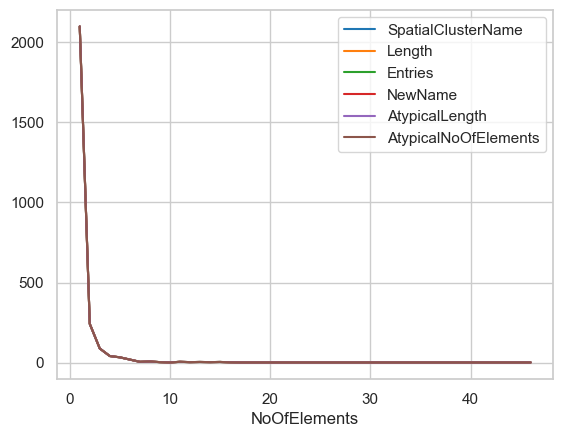

In [209]:
grpNoOfElements=spDF.groupby("NoOfElements")
grpNoOfElements.count().plot()
if saveFiguresAsPDF:
    plt.savefig('./figures/noelements_cluster.pdf')

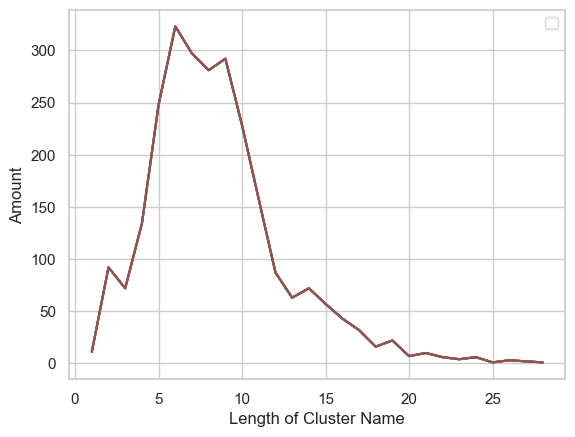

In [210]:
grpLength=spDF.groupby("Length")
grpLength.count().plot()
if saveFiguresAsPDF:
    plt.legend("")
    plt.ylabel("Amount")
    plt.xlabel("Length of Cluster Name")
    plt.savefig('./figures/length_spatialnames.pdf')

* "Poststempel", "Erscheinungsort", nicht entzifferbare Abkürzungen lassen sich so auffinden oder: St.Moritz Hotel, bzw. Kombinationen aus Verlagen und Orten; Signaturen/Referenzen: "Br117"; "VIII, 35"; (Budae,Budapest,Budapesten) wird als ein Cluster erkannt

* Excel weißt statistische Besonderheiten aus und ist alphabetisch anhand der Cluster sortiert, so kommt man in gut XX Minuten mit der Korrektur durch

* nicht alle Korrekturen sind manuell notwendig, da Ortsnamen auch Mehrsprachig in OSM oder GND(???) liegen
* Character Encoding -Probleme sind dort auch gut zu erkennen (Piešťany)

* consonant shift or sound changes

* durch die Aufbereitung in ca. 45 Minuten leistbar (inkl. Recherchen in Historischen Ortsnamen, OSM und Google)

The manual corrections are expected in a file called ``spatialnamesCorrections.xlsx``. For illustration purposes, some correction have already been made. Dots indicate rows for which the spatial name cluster will be removed.

In [211]:
spDF_manuallyCleaned=pd.read_excel("spatialnamesCorrections.xlsx")
spDF_manuallyCleaned.head(20)

,SpatialClusterName,Length,NoOfElements,Entries,NewName,AtypicalLength,AtypicalNoOfElements
0,1,1,1,1,.,True,False
1,2,1,1,2,.,True,False
2,2.,2,1,2.,.,True,False
3,50,2,1,50,.,True,False
4,??,2,1,??,.,True,False
5,A,1,1,A,.,True,False
6,A.,2,1,A.,.,True,False
7,Aarau,5,1,Aarau,NaN,False,False
8,Abdera,6,1,Abdera,NaN,False,False
9,Abel,4,1,Abel,NaN,False,False


In [380]:
df3[df3.spatialClusterName=="1"].head()

,title,creator,subject,publisher,type,format,identifier,language,date,coverage,rights,PPN,spatialClean,dateClean,spatialCluster,spatialClusterName
60755,La resignation; Op. 113 No. 2,NaN,Musiknoten,au Bureau de Musique de C.F. Peters,volume,application/mets+xml,PPN1758447710,zxx,1862,Leipzig et Berlin,Public Domain Mark 1.0,PPN1758447710,Leipzig et Berlin,1862,2573,1
60756,Gondellied; Op. 113 No. 3,NaN,Musiknoten,au Bureau de Musique de C.F. Peters,volume,application/mets+xml,PPN1758447958,zxx,1862,Leipzig et Berlin,Public Domain Mark 1.0,PPN1758447958,Leipzig et Berlin,1862,2573,1
60757,La violette; Op. 113 No. 5,NaN,Musiknoten,au Bureau de Musique de C.F. Peters,volume,application/mets+xml,PPN1758448156,zxx,1862,Leipzig et Berlin,Public Domain Mark 1.0,PPN1758448156,Leipzig et Berlin,1862,2573,1
60758,Souvenir; Nocturne : Op. 113 No. 6,NaN,Musiknoten,au Bureau de Musique de C.F. Peters,volume,application/mets+xml,PPN1758448458,zxx,1862,Leipzig et Berlin,Public Domain Mark 1.0,PPN1758448458,Leipzig et Berlin,1862,2573,1


In [381]:
# df3.ix[df3["spatialClusterName"]=="Carlsruhe", "spatialClusterName"] = "Karlsruhe"
printLog("Fixing spatial cluster names on the basis of manual corrections...")
counterRemoved=0
counterAltered=0
ignoredSpatialNamesLowerCase=[]

for row in spDF_manuallyCleaned.iterrows():
    #py27 newName=readDate=unicode(row[1]["NewName"])
    #py27 oldName=unicode(row[1]["SpatialClusterName"])
    newName=str(row[1]["NewName"])
    oldName=row[1]["SpatialClusterName"]
    
    if newName==".":
        #print("Removed: "+row[1]["SpatialClusterName"])
        #df3.ix[df3["spatialClusterName"]==oldName, "spatialClusterName"] = ""
        df3.loc[df3['spatialClusterName']==oldName, 'spatialClusterName'] = ""
        ignoredSpatialNamesLowerCase.append(oldName.lower())
        counterRemoved=counterRemoved+1
    elif newName=="nan":
        pass
    else:
        #print("Changed: "+row[1]["SpatialClusterName"])
        #df3.ix[df3["spatialClusterName"]==oldName, "spatialClusterName"] = newName
        df3.loc[df3['spatialClusterName']==oldName, 'spatialClusterName'] = newName
        counterAltered=counterAltered+1
        
printLog("Removed clusters: %i"%counterRemoved)
printLog("Altered clusters: %i"%counterAltered)
printLog("Done.")

[2023-01-02 09:34:43.343502]	Fixing spatial cluster names on the basis of manual corrections...
[2023-01-02 09:34:44.685789]	Removed clusters: 65
[2023-01-02 09:34:44.686235]	Altered clusters: 183
[2023-01-02 09:34:44.686584]	Done.


(TODO) spatialCluster-ID muss auch noch angepasst werden und der spatialClusterName-Anzahl entsprechen

In [219]:
pickleCompress('./picklez/clean_dataframe.picklez',df3)
pickleCompress('./picklez/ignoredSpatialNames.picklez',ignoredSpatialNamesLowerCase)

[2022-12-30 19:28:28.854799]	Pickling to './picklez/clean_dataframe.picklez'
[2022-12-30 19:28:32.381494]	Pickling done.
[2022-12-30 19:28:32.381950]	Pickling to './picklez/ignoredSpatialNames.picklez'
[2022-12-30 19:28:32.383263]	Pickling done.


## Augmenting the Dataset: Geodata

To plot all locations on a map, we need coordinates which are not contained in the original dataset. To obtain these coordinates we can use a web service offered by Google Maps or the OpenStreetMap project.

No matter which one you choose, we will send each _spatialClusterName_ to the web service, get its coordinates or set it as unavailable if it could not be found.

In [220]:
# uncomment only needed if you resume the notebook
df4=pickleDecompress('./picklez/clean_dataframe.picklez')
#ignoredSpatialNamesLowerCase=pickleDecompress('./picklez/ignoredSpatialNames.picklez')

# otherwise just run this line:
#df4=df3

[2022-12-30 19:28:43.026843]	Depickling from './picklez/clean_dataframe.picklez'
[2022-12-30 19:28:43.341807]	Depickling done.


Interface for the Google Maps API:

In [221]:
# not tested with Python 3
if useGoogleMapsAPI:
    # idee ist, die Algorithmen von Google zu nutzen, um mit mitunter fehlerhaften, mehrsprachigen Ortsbezeichner umzugehen
    gmaps = googlemaps.Client(key=privateGoogleKey)
    # if you re-run this cell you might want to uncomment the following line
    latLng=dict()
    printLog("Fetching geolocations from Google Maps...")
    for row in df4.iterrows():
        if not row[1]["spatialClusterName"]:
            # in some cases, i.e., when the cluster was corrected manually above, 
            # we will ignore the spatialClean replacement
            loc=row[1]["spatialClean"]
            if loc:
                if not loc.lower() in ignoredSpatialNamesLowerCase:
                    printLog("Taking %s instead."%loc)
                else:
                    loc=None
        else:
            loc=row[1]["spatialClusterName"]
        if loc:
            if loc not in latLng:
                #printLog(loc)
                try:
                    retLL=gmaps.geocode(loc)
                    if len(retLL)>0:
                        latLng[loc]=retLL[0][u'geometry'][u'location']
                    else:
                        latLng[loc]=None
                except googlemaps.exceptions.ApiError:
                    printLog("Problem fetching: "+loc)
                    latLng[loc]=None
    printLog("Done.")

    triedAgain=[]
    printLog("Fetching geolocations from Google Maps a second time (aka the brute force failover solution)...")
    for row in df4.iterrows():
        if not row[1]["spatialClusterName"]:
            loc=row[1]["spatialClean"]
        else:
            loc=row[1]["spatialClusterName"]
        if loc:
            if latLng[loc]==None:
                if loc not in triedAgain:
                    #printLog(loc)
                    triedAgain.append(loc)
                    try:
                        retLL=gmaps.geocode(loc)
                        if len(retLL)>0:
                            latLng[loc]=retLL[0][u'geometry'][u'location']
                        else:
                            latLng[loc]=None
                    except googlemaps.exceptions.ApiError:
                        printLog("Problem fetching: "+loc)
                        latLng[loc]=None
    printLog("Done.")
    pickleCompress('./picklez/geo_coordinates.picklez',latLng)
else:
    printLog("Skipping Google Map API calls.")

[2022-12-30 19:28:45.563463]	Skipping Google Map API calls.


Interface for the OpenStreetMaps API:

http://wiki.openstreetmap.org/wiki/Nominatim#Reverse_Geocoding

In [225]:
if not useGoogleMapsAPI:
    if getSpatialNamesFromOSM:
        osmNominatimURL="https://nominatim.openstreetmap.org/search?format=json&namedetails=1&q="
        # if you re-run this cell you might want to uncomment the following line
        latLng=dict()
        names=dict()
    
        maxItems=df4.shape[0]
        counter=0
    
        printLog("Fetching geolocations from OpenStreetMaps...")
        for row in df4.iterrows():
            counter=counter+1
            if counter%5000==0:
                printLog("\tProcessed %i items of %i"%(counter,maxItems))
            if not row[1]["spatialClusterName"]:
                # in some cases, i.e., when the cluster was corrected manually above, 
                # we will ignore the spatialClean replacement
                loc=str(row[1]["spatialClean"])
                if loc:
                    if not loc.lower() in ignoredSpatialNamesLowerCase:
                        printLog("No spatial cluster name for %s. Taking %s instead."%(row[1]["PPN"],loc))
                    else:
                        loc=None
            else:
                loc=str(row[1]["spatialClusterName"])
            if loc:
                if loc not in latLng:
                #printLog(loc)
                    locURL=osmNominatimURL+urllib.parse.quote(loc).replace(" ","+")
                    try:
                        data = json.load(urllib.request.urlopen(locURL))
                        latLng[loc]=dict()
                        if len(data)>0:
                            #print data[0]
                            latLng[loc][u'lat']=data[0]["lat"]
                            latLng[loc][u'lng']=data[0]["lon"]
                            #print loc
                            names[loc]=dict()
                            if len(data[0]['namedetails'])>0:
                                for k,v in data[0]['namedetails'].items():
                                    names[loc][k]=v
                            else:
                                names[loc][u'name']=loc
                                #print "No namedetails for "+loc
                            #print names[loc]
                        else:
                            latLng[loc]=None
                    except IOError:
                        printLog("\tCould not open: "+locURL)
                        pickleCompress('./picklez/save_names.picklez',names)
                        pickleCompress('./picklez/save_latLng.picklez',latLng)
                    time.sleep(1) # see http://wiki.openstreetmap.org/wiki/Nominatim_usage_policy
        printLog("Number of coordinates: %i"%len(latLng))
        printLog("Done.")
    else:
        printLog("Skipping OpenStreetMap API calls.")
else:
    printLog("Skipping OpenStreetMap API calls.")

[2022-12-30 19:29:14.998201]	Fetching geolocations from OpenStreetMaps...
[2022-12-30 19:35:13.578810]		Processed 5000 items of 120000
[2022-12-30 19:37:42.527387]		Processed 10000 items of 120000
[2022-12-30 19:40:05.621751]		Processed 15000 items of 120000
[2022-12-30 19:42:15.820621]		Processed 20000 items of 120000
[2022-12-30 19:45:26.506556]		Processed 25000 items of 120000
[2022-12-30 19:47:39.986041]		Processed 30000 items of 120000
[2022-12-30 19:49:20.072322]		Processed 35000 items of 120000
[2022-12-30 19:50:54.602913]		Processed 40000 items of 120000
[2022-12-30 19:53:02.835950]		Processed 45000 items of 120000
[2022-12-30 19:54:30.052655]		Processed 50000 items of 120000
[2022-12-30 19:54:53.305018]	No spatial cluster name for PPN1733554661. Taking Erscheinnungsort instead.
[2022-12-30 19:55:38.913254]		Processed 55000 items of 120000
[2022-12-30 19:56:29.857866]	No spatial cluster name for PPN1748194607. Taking Erschienungsort instead.
[2022-12-30 19:57:27.838889]		Proces

In [226]:
# for manual additions, you can directly pass an URL as the example below shows
#manualLocation="Kehl"
#data = json.load(urllib.urlopen("https://nominatim.openstreetmap.org/search?format=json&namedetails=1&q="+manualLocation))
#loc=manualLocation
#if len(data)>0:
#    latLng[loc][u'lat']=data[0]["lat"]
#    latLng[loc][u'lng']=data[0]["lon"]
#    names[loc]=dict()
#    if len(data[0]['namedetails'])>0:
#        for k,v in data[0]['namedetails'].items():
#            names[loc][k]=v
#    else:
#        names[loc][u'name']=loc
#else:
#    latLng[loc]=None

In [227]:
# save everything
if not useGoogleMapsAPI:
    if getSpatialNamesFromOSM:
        pickleCompress('./picklez/osm_names.picklez',names)
        pickleCompress('./picklez/osm_latLng.picklez',latLng)

[2022-12-31 06:44:41.443489]	Pickling to './picklez/osm_names.picklez'
[2022-12-31 06:44:41.579547]	Pickling done.
[2022-12-31 06:44:41.580010]	Pickling to './picklez/osm_latLng.picklez'
[2022-12-31 06:44:41.592030]	Pickling done.


In [228]:
if useGoogleMapsAPI:
    latLng=pickleDecompress('./picklez/geo_coordinates.picklez')
else:
    latLng=pickleDecompress('./picklez/osm_latLng.picklez')
    osmNames=pickleDecompress('./picklez/osm_names.picklez')

[2022-12-31 06:44:50.681752]	Depickling from './picklez/osm_latLng.picklez'
[2022-12-31 06:44:50.688698]	Depickling done.
[2022-12-31 06:44:50.690309]	Depickling from './picklez/osm_names.picklez'
[2022-12-31 06:44:50.712173]	Depickling done.


Finally, we save _latitude_ and _longitude_ to separate columns for each record.

In [229]:
def getLat(spatialName):
    if spatialName:
        if spatialName in latLng:
            if latLng[spatialName]:
                return latLng[spatialName][u'lat']
            else:
                return np.nan
    else:
        return np.nan

def getLng(spatialName):
    if spatialName:
        if spatialName in latLng:
            if latLng[spatialName]:
                return latLng[spatialName][u'lng']
            else:
                return np.nan
    else:
        return np.nan

df4['latitude']=df4['spatialClusterName'].apply(getLat)
df4['longitude']=df4['spatialClusterName'].apply(getLng)

In [230]:
# overwrite every "nulled" column (i.e. NULL or NaN) with -1
# the old way..
#df4.ix[df4["dateClean"].isnull(), "dateClean"] = -1
#df4.ix[df4["dateClean"]=='nan', "dateClean"] = -1

df4.loc[df4['dateClean'].isnull(), 'dateClean'] = -1
df4.loc[df4['dateClean']=='nan', 'dateClean'] = -1


## Augmenting the Dataset: Centuries

Another simple example of data augmentation is the addition of a _century_ column that is derrived from the cleaned data of each record.

In [231]:
df4["century"]=df4["dateClean"].apply(lambda x: int(int(x)/100)) # calculate the century out of the given date
df4.head(20)

,title,creator,subject,publisher,type,format,identifier,language,date,coverage,rights,PPN,spatialClean,dateClean,spatialCluster,spatialClusterName,latitude,longitude,century
0,"Collegium Ethicum, In Quo De Summo Hominis Bon...","Liebenthal, Christianus",Historische Drucke,Hampelius,monograph,application/mets+xml,PPN1000000974,lat,1620,Giessae Hessorum,Public Domain Mark 1.0,PPN1000000974,Giessae,1620,,Giessae,NaN,NaN,16
1,"Augustini Niphi, Philosophi Suessani De Auguri...","Niphus, Augustinus",Historische Drucke,Egenolphus,monograph,application/mets+xml,PPN100000127X,lat,1614,Marpurgi,Public Domain Mark 1.0,PPN100000127X,Marpurgi,1614,1528,Marpurgi,46.560287,15.6480467,16
2,Concerto pour la Flûte avec Accompagnement de ...,"Danzi, Franz",Musiknoten,Breitkopf & Härtel,monograph,application/mets+xml,PPN1000006808,NaN,1806,Leipsic,CC BY-NC-SA 4.0 International,PPN1000006808,Leipsic,1806,894,Leipsic,41.0983847,-83.9846655,18
3,Schuldige Condolentz-Zeilen Womit seinem Gelie...,"Koltemann, Otto Benedict",Historische Drucke,Königliche privil. Buchdruckerey,monograph,application/mets+xml,PPN1000056597,ger,1719,Glückstadt,Public Domain Mark 1.0,PPN1000056597,Glückstadt,1719,108,Glückstadt,53.787927,9.4238157,17
4,Johann Friedrich Böttchers der Arzney und Wund...,"Böttcher, Johann Friedrich",Historische Drucke,Oehmigke,monograph,application/mets+xml,PPN1000059669,ger,1796,Berlin,Public Domain Mark 1.0,PPN1000059669,Berlin,1796,1555,Berlin,52.5170365,13.3888599,17
5,Vom Aktienwesen; eine geschäftliche Betrachtung,"Rathenau, Walther",Historische Drucke,S. Fischer-Verlag,monograph,application/mets+xml,PPN1000065081,ger,1917,Berlin,Public Domain Mark 1.0,PPN1000065081,Berlin,1917,1555,Berlin,52.5170365,13.3888599,19
6,"Iustus Et Aequus Iudex, Quem Post emensum legi...","Senutti, Wolffgangus Nicolaus Joannes",Historische Drucke,Schwendimann,monograph,application/mets+xml,PPN1000065707,lat,1716,Viennae Austriae,Public Domain Mark 1.0,PPN1000065707,Viennae,1716,571,Viennae,NaN,NaN,17
7,Przewodnik dla Matki Chrzescijańskiéj we wycho...,"Cramer, Wilhelm",Historische Drucke,Nakładem Wydawnictwa Jim ks. Fr. Baźyńskiego (...,monograph,application/mets+xml,PPN1000067858,pol,1878,W Poznaniu,Public Domain Mark 1.0,PPN1000067858,W,1878,2287,,NaN,NaN,18
8,Disputatio Philologica De Synonymis Dei Hebrai...,"Friderici, Valentin",Historische Drucke,Wittigau,monograph,application/mets+xml,PPN1000074277,lat,1673,Lipsiae,Public Domain Mark 1.0,PPN1000074277,Lipsiae,1673,894,Leipsic,41.0983847,-83.9846655,16
9,Exercitatio Philologica De voce šāmayîm Illust...,"Thym, Gottfried",Historische Drucke,Literis Colerianis,monograph,application/mets+xml,PPN1000076849,lat,1670,Lipsiae,Public Domain Mark 1.0,PPN1000076849,Lipsiae,1670,894,Leipsic,41.0983847,-83.9846655,16


Now we can group our dataset by century and reveal how the available media is distributed over the centuries.

In [232]:
grpCentury=df4.groupby("century")
grpCentury.describe()

title                                                                 creator                                                               subject                                               publisher                                     type                           format                                     identifier                            language                      date                    coverage                                          rights         \
         count unique                                                top  freq   count unique                                               top freq   count unique                             top   freq     count unique                   top freq  count unique         top   freq  count unique                   top   freq      count unique            top freq    count unique  top   freq  count unique   top  freq    count unique                         top  freq  count unique   
century                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
0         4175   3199                                 Tibetische Urkunde   306    1685    833                             Beethoven, Ludwig van  107    4171     24                           Musik    688       117     89                 Bruns    7   4175      7  manuscript   2458   4175      1  application/mets+xml   4175       4175   4174  PPN330613113X    2     2264     47  tib    606   1249    748  18XX   184      932    159                      Berlin   118   1866      4   
2            2      2  Das Paradies und die Peri; V (8), Coro, orch; ...     1       2      1                                  Schumann, Robert    2       2      1                      Musiknoten      2         0      0                   NaN  NaN      2      1  manuscript      2      2      1  application/mets+xml      2          2      2  PPN1041188900    1        0      0  NaN    NaN      2      2   212     1        0      0                         NaN   NaN      2      1   
3            2      2  Fidelio. Auszüge; B-Dur; LvBWV op.72; KinB 72/...     1       2      1                             Beethoven, Ludwig van    2       2      1                      Musiknoten      2         0      0                   NaN  NaN      2      1  manuscript      2      2      1  application/mets+xml      2          2      2  PPN1041276419    1        0      0  NaN    NaN      2      1   300     2        0      0                         NaN   NaN      2      1   
4            2      2      Requiems; V (4), Coro, orch; McCS 148; op.148     1       1      1                                  Schumann, Robert    1       2      2                      Musiknoten      1         0      0                   NaN  NaN      2      1  manuscript      2      2      1  application/mets+xml      2          2      2  PPN1041187335    1        1      1  syr      1      2      2   400     1        0      0                         NaN   NaN      2      1   
6           12     12                           al- Qurʾān [DAM 01-28.2]     1       1      1                             Beethoven, Ludwig van    1      12      2  Außereuropäische Handschriften     11         0      0                   NaN  NaN     12      1  manuscript     12     12      1  application/mets+xml     12         12     12  PPN1778038050    1       11      1  ara     11     12      2   650    11        0      0                         NaN   NaN     12      2   
7           90     90                           al- Qurʾān [DAM 18-15.2]     1       1      1  Mutanabbī, Abu-'ṭ-Ṭaiyib Aḥmad Ibn-al-Ḥusain al-    1     

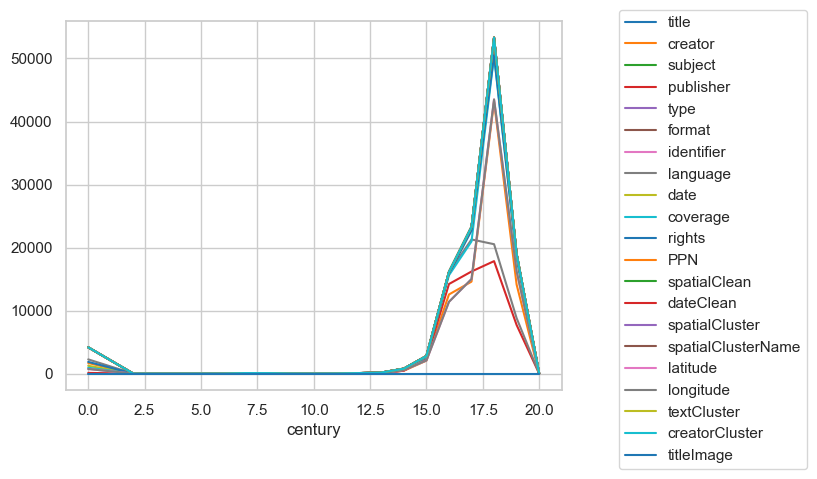

In [383]:
ax=grpCentury.count().plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))

## Augmenting the Dataset: Text-based Clustering

Besides its utility for cleaning up data, clustering can also be used to discover new patterns in your data. We will try to find out if there are interesting patterns hidden in the _title_ and _creator_ columns.

First, we will check if the titles are unique. Subsequently, a text corpus of the titles for later processing is created.

In [385]:
printLog("Number of unique title fields %i"%len(df4.title.unique()))

[2023-01-02 10:58:01.207112]	Number of unique title fields 102550


In [235]:
#title soll geclustert werden -> textCluster
corpus=df4.title.astype(str)
corpus

0         Collegium Ethicum, In Quo De Summo Hominis Bon...
1         Augustini Niphi, Philosophi Suessani De Auguri...
2         Concerto pour la Flûte avec Accompagnement de ...
3         Schuldige Condolentz-Zeilen Womit seinem Gelie...
4         Johann Friedrich Böttchers der Arzney und Wund...
                                ...                        
119995    Brief von Adelbert von Chamisso an Hippolyte d...
119996    Brief von Adelbert von Chamisso an Hippolyte d...
119997    Brief von Adelbert von Chamisso an Hippolyte d...
119998    Brief von Adelbert von Chamisso an Hippolyte d...
119999    Brief von Adelbert von Chamisso an Hippolyte d...
Name: title, Length: 120000, dtype: object

The next cell will take a while to compute depending on your computer and the size of the corpus. To give an example, the following performance could be observed on a MacBook Pro (13-inch, 2018, Four Thunderbolt 3 Ports, 2,7 GHz Intel Core i7, 16 GB RAM):
```
[2019-02-25 11:08:53.568526]	Clustering text with cluster target size 5000
[2019-02-25 11:08:53.569143]		 Preparing tf*idf model
[2019-02-25 11:08:56.634801]		 Number of feature names: 125000
[2019-02-25 11:08:56.635519]		 K-Means clustering
[2019-02-25 11:17:49.427231]	Done.
```

The cell takes the created title corpus, produces a _tf*idf_ model from it and clusters the results using a k-means algorithm.


In [236]:
# in Python 3 you cannot save files over 4 GB, hence we have to run the clustering everytime  :-/
true_k=1000

if allowComputationallyExpensiveCalculations:
    printLog("Clustering text with cluster target size %i"%true_k)
    printLog("\t Preparing tf*idf model")
    # from an analysis we know that there are 167,715 different words in the corpus
    # to speed up processing, we limit the vocabulary size to 80.000
    tfidfvectorizer = TfidfVectorizer(min_df=1,max_features=80000) #max_features is used to limit the vocabulary size 
    Xtfidf=tfidfvectorizer.fit_transform(corpus)
    featNames=tfidfvectorizer.get_feature_names_out()
    printLog("\t Number of feature names: %i"%len(featNames))

    printLog("\t K-Means clustering")
    km=MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=100)#,verbose=1) # verbose switch for debug
    # fit the k-means algorithm on the data created above
    km.fit(Xtfidf)
    printLog("Pickling...")
    if sys.version_info.major<3:
        pickleCompress('./picklez/textClustersK_'+str(true_k)+'.picklez',km)
else:
    km=pickleDecompress('./picklez/textClustersK_'+str(true_k)+'.picklez')
    printLog("\t Updating Dataframe")
# add the detected clusters as a new column to the original data frame
df4['textCluster']=km.labels_
printLog("Done.")

[2022-12-31 06:45:27.578627]	Clustering text with cluster target size 1000
[2022-12-31 06:45:27.579504]		 Preparing tf*idf model
[2022-12-31 06:45:29.154076]		 Number of feature names: 80000
[2022-12-31 06:45:29.154484]		 K-Means clustering


/Users/david/src/SBBrowse2018/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2022-12-31 06:46:15.980767]	Pickling...
[2022-12-31 06:46:15.986206]	Done.


In [237]:
if allowComputationallyExpensiveCalculations:
    # group the data by the cluster and describe it
    df4.groupby('textCluster').describe()

In [238]:
df4=df4.sort_values(by="textCluster")
df4[['PPN','title','textCluster']].tail()

,PPN,title,textCluster
110236,PPN723855226,Kriegszeit-Programm für einen Besuch Berlins a...,999
54760,PPN1739153944,Im Klementenhof; Roman,999
95140,PPN668423889,"Proprium Missalis Ratisbonensis, Jussu & Aucto...",999
54761,PPN1739154592,Im Klementenhof,999
5498,PPN1018539077,Elf Jahre Freimaurer!,999


Next, we do the same with the _creator_ column.

In [239]:
#creator soll geclustert werden -> creatorCluster
corpus=df4.creator.astype(str)
corpus

23762     Dittersdorf, Carl Ditters von
60236                 Sperger, Johannes
60235                 Sperger, Johannes
10731        Bach, Carl Philipp Emanuel
95242             Agthe, Karl Christian
                      ...              
110236                  Grantzow, Eugen
54760                   Telmann, Konrad
95140                               nan
54761                   Telmann, Konrad
5498              Daiber, Albert Ludwig
Name: creator, Length: 120000, dtype: object

In [240]:
printLog("Number of unique creator fields %i"%len(df4.creator.unique()))

[2022-12-31 06:46:31.176218]	Number of unique creator fields 29543


```
[2019-02-25 11:18:40.288281]	Clustering text with cluster target size 20000
[2019-02-25 11:18:40.289133]		 Preparing tf*idf model
[2019-02-25 11:18:40.958502]		 Number of feature names: 26575
[2019-02-25 11:18:40.959311]		 K-Means clustering
[2019-02-25 11:26:49.960392]	Done.
```

In [241]:
true_k=20000

if sys.version_info.major>=3 or allowComputationallyExpensiveCalculations:
    printLog("Clustering text with cluster target size %i"%true_k)
    printLog("\t Preparing tf*idf model")
    tfidfvectorizer = TfidfVectorizer(min_df=1) #max_features setzen?
    Xtfidf=tfidfvectorizer.fit_transform(corpus)
    featNames=tfidfvectorizer.get_feature_names_out()
    printLog("\t Number of feature names: %i"%len(featNames))

    printLog("\t K-Means clustering")
    km=MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=100)
    # fit the k-means algorithm on the data created above
    km.fit(Xtfidf)
    if sys.version_info.major<3:
        pickleCompress('./picklez/creatorClustersK_'+str(true_k)+'.picklez',km)
else:
    km=pickleDecompress('./picklez/creatorClustersK_'+str(true_k)+'.picklez')

printLog("Done.")

[2022-12-31 06:46:32.699341]	Clustering text with cluster target size 20000
[2022-12-31 06:46:32.700332]		 Preparing tf*idf model
[2022-12-31 06:46:33.021123]		 Number of feature names: 22975
[2022-12-31 06:46:33.021590]		 K-Means clustering


/Users/david/src/SBBrowse2018/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2022-12-31 06:50:56.601845]	Done.


In [242]:
# add the detected clusters as a new column to the original data frame
printLog("\t Updating Dataframe")
df4['creatorCluster']=km.labels_

df4=df4.sort_values(by="creatorCluster")
df4[['PPN','creator','creatorCluster']].tail()

[2022-12-31 06:50:56.612032]		 Updating Dataframe


,PPN,creator,creatorCluster
77634,PPN614857015,"Coeverden, Carel Cornelis Lodewyk van",14894
114751,PPN731460227,"Weingart, Friedrich",14895
6573,PPN1023179016,"Donauer, Johann Christoph",14896
115845,PPN733804365,"Silberschlag, Esaias",14897
10571,PPN1030579083,"Wilhelm Friedrich <Brandenburg-Ansbach, Markgraf>",14898


https://github.com/elektrobohemian/StabiHacks/blob/master/sbbget/addFirstPages.py will create the needed images and requires a PPN list created as follows

<a id='#continue_from_here'></a>

In [243]:
df4.PPN.to_csv("120k_ppn_list_df4.csv",index=False,header=False)

## Augmenting the Dataset: Images

(TODO) skip

In [244]:
#imageBasePath="/Users/david/src/__datasets/sbb/"
imageBasePath="/Users/david/temp/image_test/data/1024/"
def getImageAvailability(ppn):
    if ppn:
        if os.path.exists(imageBasePath+ppn+".jpg"):
            return ppn+".jpg"
        elif os.path.exists(imageBasePath+"firstpages/"+ppn+".jpg"):
            return "firstpages/"+ppn+".jpg"
        else:
            if os.path.exists(imageBasePath+"titlepages/"+ppn+".jpg"):
                return "titlepages/"+ppn+".jpg"
            else:
                return None
    else:
        return None

printLog("Checking image availability...")
df4['titleImage']=df4['PPN'].apply(getImageAvailability)

recordsWithTitleImage=df4[df4.titleImage.notnull()].shape[0]
recordsWithoutTitleImage=df4[df4.titleImage.isnull()].shape[0]
printLog("Records with title image: %i\twithout title image (multi-volumes): %i"%(recordsWithTitleImage,recordsWithoutTitleImage))
printLog("Done.")

[2022-12-31 06:50:56.882944]	Checking image availability...
[2022-12-31 06:50:57.395911]	Records with title image: 0	without title image (multi-volumes): 120000
[2022-12-31 06:50:57.396359]	Done.


In [245]:
#df_bak=df4
df4[df4.PPN=="PPN57346250X"]

,title,creator,subject,publisher,type,format,identifier,language,date,coverage,rights,PPN,spatialClean,dateClean,spatialCluster,spatialClusterName,latitude,longitude,century,textCluster,creatorCluster,titleImage
74757,"M. Georgii Gutkii, Gymnasii Berlinensis Rector...","Gutke, Georg",Historische Drucke,Kallius,monograph,application/mets+xml,PPN57346250X,lat,1625,Berolini,Public Domain Mark 1.0,PPN57346250X,Berolini,1625,1555,Berlin,52.5170365,13.3888599,16,103,5018,None


In [246]:
kjl='Kinder- und Jugendbücher'
einbl='Einblattdrucke'

df_thematical=df4[df4.subject==kjl]
df_thematical.shape

(2707, 22)

In [247]:
df4[df4.titleImage.notnull()].to_csv("cleanedData_wImg.csv",sep=',',header=True, index=False, encoding='utf-8')

In [248]:
df_thematical[df_thematical.titleImage.notnull()].to_csv("cleanedData_wImg_theme.csv",sep=',',header=True, index=False, encoding='utf-8')

In [249]:
pickleCompress('./picklez/clean_dataframe_with_century.picklez',df4)

[2022-12-31 06:50:57.488605]	Pickling to './picklez/clean_dataframe_with_century.picklez'
[2022-12-31 06:51:03.212694]	Pickling done.


In [250]:
df4.to_csv("cleanedData.csv",sep=';',header=True, index=False, encoding='utf-8')
df4.to_excel("cleanedData.xlsx",header=True, index=False)

## Augmenting the Dataset: A Creation and Its Place of Origin - Graphing the Library World

(It is safe to continue from here if you resume the notebook.)

In [251]:
# if you have run this notebook from top to bottom, you don't have to reload the data
df4=pickleDecompress('./picklez/clean_dataframe_with_century.picklez')
grpCentury=df4.groupby("century")
#df4.shape

[2022-12-31 06:53:51.412472]	Depickling from './picklez/clean_dataframe_with_century.picklez'
[2022-12-31 06:53:51.771287]	Depickling done.


### Algorithmic Preparations

To create the network graphs below, we have to access the created dataframe very often. This would be possible by using a loop running over ``df4[df4.PPN==ppn].iloc[-1]['title']``. This loop would run for about 40 minutes. If we create a look-up dictionary before, we can speed up the processing to about 40 seconds.

In a way, this resembles the hash-based data access paradigms discussed in the lecture.

In [253]:
printLog("Creating PPN look-up table of %i unique PPNs."%len(df4.PPN.unique()))
ppnLookup=dict()
for row in df4.iterrows():
    ppn=readDate=str(row[1]["PPN"])
    if ppn not in ppnLookup:
        ppnLookup[ppn]=dict()
    # it is redundant but handy for later JSON exports to save the PPN as a value as well
    ppnLookup[ppn]["ppn"]=ppn
    ppnLookup[ppn]["dateClean"]=str(row[1]["dateClean"])
    ppnLookup[ppn]["title"]=str(row[1]["title"])
    ppnLookup[ppn]["creator"]=str(row[1]["creator"])
    
    if not row[1]["spatialClusterName"]:
        if row[1]["spatialClean"]:
            ppnLookup[ppn]["spatialClusterName"]=row[1]["spatialClean"]
        else:
            ppnLookup[ppn]["spatialClusterName"]="None"
    else:
        ppnLookup[ppn]["spatialClusterName"]=row[1]["spatialClusterName"] 
    ppnLookup[ppn]['spatialClean']=row[1]["spatialClean"]
    ppnLookup[ppn]['spatialRaw']=str(row[1]["coverage"])
    ppnLookup[ppn]['mediatype']=str(row[1]["type"])
    ppnLookup[ppn]['subject']=str(row[1]["subject"])
    # daz
    #ppnLookup[ppn]['source']=str(row[1]["source"])
    ppnLookup[ppn]['publisher']=str(row[1]["publisher"])
    #ppnLookup[ppn]['alternative']=str(row[1]["alternative"])
    ppnLookup[ppn]['lat']=str(row[1]["latitude"])
    ppnLookup[ppn]['lng']=str(row[1]["longitude"])
    ppnLookup[ppn]['textCluster']=str(row[1]["textCluster"])
    ppnLookup[ppn]['creatorCluster']=str(row[1]["creatorCluster"])
    ppnLookup[ppn]['titleImage']=str(row[1]["titleImage"])
    
pickleCompress("./picklez/ppnLookup.picklez",ppnLookup)
printLog("Done.")

[2022-12-31 06:53:57.723969]	Creating PPN look-up table of 119997 unique PPNs.
[2022-12-31 06:54:03.907882]	Pickling to './picklez/ppnLookup.picklez'
[2022-12-31 06:54:05.492242]	Pickling done.
[2022-12-31 06:54:05.492692]	Done.


In [254]:
#serialize data per PPN; one large file would be more than 80 MB and thus too much for a transmission to a browser
if serializePPNLookup2JSON:
    printLog("Serializing PPN lookup table to JSON in directory:\n\t"+jsonWebDir)
    for k in ppnLookup:
        dump=json.dumps(ppnLookup[k])

        jsonFile = open(jsonWebDir+k+".json", "w")
        jsonFile.write(dump)
        jsonFile.close()
    printLog("Done.")

### Creating Network Graphs

In the next cells, we create different networks graphs, e.g. one linking publishers/creators with places.

In [255]:
def createGraph(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()

    rowCount=0
    seenCreators=[]
    seenLocations=[]
    for row in consideredDataFrame.iterrows():
        rowCount=rowCount+1
        #if rowCount%1000==0:
        #    printLog("Processed %i rows..."%rowCount)
        ppn=row[1]["PPN"]
        creator=str(row[1]["publisher"]).upper()
        if creator=="NAN":
            creator=str(row[1]["creator"]).upper()
        if creator=="NAN":
            creator="Unknown creator"
        
        location=row[1]["spatialClusterName"]
        if location=="NAN":
            location="s. l."
        elif not location:
            location="s. l."
        year=row[1]["dateClean"]
        subject=row[1]["subject"]
        
        #if not creator in G.nodes():
        #if not creator in seenCreators:
        
        G.add_node(creator)
        if not creator=="Unknown creator":
            # the name attribute will be helpful for D3.js visualizations
            G.nodes[creator]['name'] = creator
            G.nodes[creator]['year'] = year
            G.nodes[creator]['type'] = "creator"
            G.nodes[creator]['subject']=subject
            G.nodes[creator]['century']=row[1]["century"]
            seenCreators.append(creator)
        else:
            G.nodes[creator]['name'] = creator
            G.nodes[creator]['year'] = year
            G.nodes[creator]['type'] = "no_creator"
        
        #if not location in G.nodes():
        #if not location in seenLocations:
       
        # the name attribute will be helpful for D3.js visualizations
        if not location=="s. l.":
            G.add_node(location)
            G.nodes[location]['name'] = location
            G.nodes[location]['year'] = year
            G.nodes[location]['type'] = "location"
            seenLocations.append(location)
            G.add_edge(creator,location)
        else:
            pass
        # if we would like to add the unknown location, uncomment the following lines and the comment the last line
            #G.add_node(location)
            #G.node[location]['name'] = location
            #G.node[location]['year'] = year
            #G.node[location]['type'] = "no_location"
    
        #print location
        #print creator
        #print "* * *"
    return G

In [256]:
printLog("Creating graphs and additional data...")

graphsPerCentury=dict()
ppnPerCentury=OrderedDict()
for century in range(7,21): # we know that there are only media from the 7th century on
    if century in grpCentury.groups:
        centDF=grpCentury.get_group(century)
        returnedGraph=createGraph(centDF)
        graphsPerCentury[century]=returnedGraph
        printLog("Graph for century %i built with %i nodes and %i edges."%(century, len(returnedGraph.nodes()),len(returnedGraph.edges())))
        # export as GraphML, which can be read by Gephi
        nx.write_gml(returnedGraph,"graphs/century_"+str(century)+".gml")
        
        # now save the PPNs
        ppnPerCentury[century]=[]
        for row in centDF.iterrows():
            ppn=row[1]["PPN"]
            ppnPerCentury[century].append(ppn)

# create the full graph
returnedGraph=createGraph(df4)
printLog("Graph for all centuries built with %i nodes and %i edges."%(len(returnedGraph.nodes()),len(returnedGraph.edges())))
nx.write_gml(returnedGraph,"graphs/all_centuries.gml")
printLog("Done.")

[2022-12-31 06:54:09.741814]	Creating graphs and additional data...
[2022-12-31 06:54:09.899675]	Graph for century 7 built with 4 nodes and 2 edges.
[2022-12-31 06:54:09.920893]	Graph for century 8 built with 11 nodes and 6 edges.
[2022-12-31 06:54:09.927336]	Graph for century 9 built with 7 nodes and 1 edges.
[2022-12-31 06:54:09.930625]	Graph for century 10 built with 5 nodes and 2 edges.
[2022-12-31 06:54:09.933402]	Graph for century 11 built with 26 nodes and 10 edges.
[2022-12-31 06:54:09.943768]	Graph for century 12 built with 72 nodes and 21 edges.
[2022-12-31 06:54:09.957756]	Graph for century 13 built with 105 nodes and 32 edges.
[2022-12-31 06:54:10.003662]	Graph for century 14 built with 458 nodes and 316 edges.
[2022-12-31 06:54:10.152715]	Graph for century 15 built with 1022 nodes and 743 edges.
[2022-12-31 06:54:10.923747]	Graph for century 16 built with 3964 nodes and 3648 edges.
[2022-12-31 06:54:12.382127]	Graph for century 17 built with 7332 nodes and 6658 edges.
[202

In [257]:
def createFullGraph(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()

    rowCount=0
    seenCreators=[]
    seenLocations=[]
    for row in consideredDataFrame.iterrows():
        rowCount=rowCount+1
        #if rowCount%1000==0:
        #    printLog("Processed %i rows..."%rowCount)
        ppn=row[1]["PPN"]
        creator=str(row[1]["publisher"]).upper()
        if creator=="NAN":
            creator=str(row[1]["creator"]).upper()
        if creator=="NAN":
            creator="Unknown creator"
        
        location=row[1]["spatialClusterName"]
        if location=="NAN":
            location="s. l."
        elif not location:
            location="s. l."
        year=row[1]["dateClean"]
        subject=row[1]["subject"]
        
        #if not creator in G.nodes():
        #if not creator in seenCreators:
        
        G.add_node(creator)
        if not creator=="Unknown creator":
            # the name attribute will be helpful for D3.js visualizations
            G.nodes[creator]['name'] = creator
            G.nodes[creator]['year'] = year
            G.nodes[creator]['type'] = "creator"
            G.nodes[creator]['subject']=subject
            G.nodes[creator]['century']=row[1]["century"]
            seenCreators.append(creator)
        else:
            G.nodes[creator]['name'] = creator
            G.nodes[creator]['year'] = year
            G.nodes[creator]['type'] = "no_creator"
        
        #if not location in G.nodes():
        #if not location in seenLocations:
       
        # the name attribute will be helpful for D3.js visualizations
        if not location=="s. l.":
            G.add_node(location)
            G.nodes[location]['name'] = location
            G.nodes[location]['year'] = year
            G.nodes[location]['type'] = "location"
            seenLocations.append(location)
            G.add_edge(creator,location)
        else:
            pass
        # if we would like to add the unknown location, uncomment the following lines and the comment the last line
            #G.add_node(location)
            #G.node[location]['name'] = location
            #G.node[location]['year'] = year
            #G.node[location]['type'] = "no_location"
    
        #print location
        #print creator
        #print "* * *"
        
        G.add_node(ppn)
        G.nodes[ppn]['name'] = str(ppn)
        G.nodes[ppn]['year'] = year
        G.nodes[ppn]['type'] = "PPN"
        G.nodes[ppn]['century']=row[1]["century"]
        G.add_edge(ppn,creator)

    return G

In [258]:
printLog("Creating graphs incl. PPNs...")

graphsPerCentury=dict()
for century in range(7,21): # we know that there are only media from the 7th century on
    if century in grpCentury.groups:
        centDF=grpCentury.get_group(century)
        returnedGraph=createFullGraph(centDF)
        graphsPerCentury[century]=returnedGraph
        gmlPath="graphs/century_ppn_"+str(century)+".gml"
        # export as GraphML, which can be read by Gephi
        nx.write_gml(returnedGraph,gmlPath)
        printLog("Graph for century %i built with %i nodes and %i edges (see %s)."%(century, len(returnedGraph.nodes()),len(returnedGraph.edges()),gmlPath))
        

# create the full graph
returnedGraph=createFullGraph(df4)
gmlPath="graphs/all_centuries_ppn.gml"
nx.write_gml(returnedGraph,gmlPath)
printLog("Graph for all centuries built with %i nodes and %i edges (see %s)."%(len(returnedGraph.nodes()),len(returnedGraph.edges()),gmlPath))
printLog("Done.")

[2022-12-31 06:54:23.376669]	Creating graphs incl. PPNs...
[2022-12-31 06:54:23.403962]	Graph for century 7 built with 94 nodes and 92 edges (see graphs/century_ppn_7.gml).
[2022-12-31 06:54:23.410812]	Graph for century 8 built with 91 nodes and 86 edges (see graphs/century_ppn_8.gml).
[2022-12-31 06:54:23.414110]	Graph for century 9 built with 30 nodes and 24 edges (see graphs/century_ppn_9.gml).
[2022-12-31 06:54:23.416207]	Graph for century 10 built with 16 nodes and 13 edges (see graphs/century_ppn_10.gml).
[2022-12-31 06:54:23.418999]	Graph for century 11 built with 51 nodes and 35 edges (see graphs/century_ppn_11.gml).
[2022-12-31 06:54:23.429239]	Graph for century 12 built with 159 nodes and 108 edges (see graphs/century_ppn_12.gml).
[2022-12-31 06:54:23.443449]	Graph for century 13 built with 278 nodes and 205 edges (see graphs/century_ppn_13.gml).
[2022-12-31 06:54:23.500021]	Graph for century 14 built with 1254 nodes and 1112 edges (see graphs/century_ppn_14.gml).
[2022-12-31

In [259]:
# takes ca. 45 min for a graph built with 16368 nodes and 18539 edges on my MacBook Pro, i.e., with the full data set
# with http://networkx.github.io/documentation/latest/reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout
# theory behind it: https://en.wikipedia.org/wiki/Force-directed_graph_drawing
#printLog("Preparing to draw...")

#nx.draw(G)
#plt.savefig("graph.pdf")
#printLog("Done.")

generic graph building

In [260]:
def createGenericGraph(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()

    rowCount=0
    seenCreators=[]
    seenLocations=[]
    # [u'PPN', u'alternative', u'creator', u'dataProvider', u'date', 
    # u'description', u'format', u'identifier', u'isShownAt', u'issued', 
    # u'object', u'provider', u'publisher', u'relation', u'rights', u'source', 
    # u'spatial', u'subject', u'title', u'type', u'spatialClean', u'dateClean', 
    # u'spatialCluster', u'spatialClusterName', u'latitude', u'longitude', u'century']
    ignoreList=[u'rights', u'issued',u'source',u'spatial',u'dataProvider', u'date',u'format',u'spatialCluster',u'century', u'provider']
    for row in consideredDataFrame.iterrows():#itertuples(): 
        ppn=val=row[1]["PPN"]
        G.add_node(ppn)
        G.nodes[ppn]['name'] = ppn
        G.nodes[ppn]['type'] = "PPN"
            
        keys=row[1].keys()
        for k in keys:
            elementEmpty=False
            if k not in ignoreList:
                #print k
                val=row[1][k]
                if val: 
                    if type(val) is float:
                        if not math.isnan(val):
                            #print row[1][k]
                            pass
                        else:
                            #print "I DON'T KNOW!"
                            elementEmpty=True
                    else:
                        #print row[1][k]
                        pass
                else:
                    #print "I DON'T KNOW!"
                    elementEmpty=True
                
                # only process non-empty elements
                if not elementEmpty:
                    if not val in G.nodes():
                        G.add_node(val)
                        G.nodes[val]['name'] = val
                        G.nodes[val]['type'] = k
                    
                    G.add_edge(ppn,val)
            
        # spatialClean auf spatialClusterName binden, den rest dann mit spatialClusterName
        # spatialClusterName erhält als Attribut latitude/longitude

       

    return G

In [261]:
if allowComputationallyExpensiveCalculations:
    saveDir="./graphs/generics/"
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
        
    printLog("Creating graphs incl. PPNs...")

    graphsPerCentury=dict()
    for century in range(7,21):#(7,21): # we know that there are only media from the 7th century on
        if century in grpCentury.groups:
            centDF=grpCentury.get_group(century)
            returnedGraph=createGenericGraph(centDF)
            graphsPerCentury[century]=returnedGraph
            gmlPath="graphs/generics/full_"+str(century)+".gml"
            # export as GraphML, which can be read by Gephi
            nx.write_gml(returnedGraph,gmlPath)
            printLog("Graph for century %i built with %i nodes and %i edges (see %s)."%(century, len(returnedGraph.nodes()),len(returnedGraph.edges()),gmlPath))
    printLog("Done.")

[2022-12-31 06:54:37.150948]	Creating graphs incl. PPNs...
[2022-12-31 06:54:37.234682]	Graph for century 7 built with 208 nodes and 638 edges (see graphs/generics/full_7.gml).
[2022-12-31 06:54:37.244449]	Graph for century 8 built with 216 nodes and 592 edges (see graphs/generics/full_8.gml).
[2022-12-31 06:54:37.248930]	Graph for century 9 built with 76 nodes and 174 edges (see graphs/generics/full_9.gml).
[2022-12-31 06:54:37.251985]	Graph for century 10 built with 54 nodes and 86 edges (see graphs/generics/full_10.gml).
[2022-12-31 06:54:37.260207]	Graph for century 11 built with 150 nodes and 234 edges (see graphs/generics/full_11.gml).
[2022-12-31 06:54:37.273455]	Graph for century 12 built with 405 nodes and 797 edges (see graphs/generics/full_12.gml).
[2022-12-31 06:54:37.302141]	Graph for century 13 built with 642 nodes and 1526 edges (see graphs/generics/full_13.gml).
[2022-12-31 06:54:37.404515]	Graph for century 14 built with 2779 nodes and 8882 edges (see graphs/generics/f

<a id='continue_from_here'></a>
# TO DO


Graph mit allen Städten und PPNs eines Spatial Clusters

In the [next step](ImageProcessing.ipynb) we will work with image data. (Coming soon.)

[Back to top of page...](#top_of_page)